## Install Libs

# **Q1.** **Model Building**

In [4]:
#!pip install sqlalchemy==1.4.25
#!pip install pandasql
#!pip install apsw
!pip install shap

## Import packages, set configs, load data

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
import xgboost as xgb

from itertools import combinations
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [6]:
#Loading all the required files in dataframe
financial_ratios = pd.read_csv('Company_Financial_Ratios2022.csv')
industry_sector_info = pd.read_excel('Industry_Sector_Info.xlsx', sheet_name='Sheet1')
marketcap = pd.read_excel('MarketCap_Data.xlsx', sheet_name='Sheet1')
stock_returns_data = pd.read_excel('Stock_Returns_Data2022_v0.xlsx', sheet_name='stock returns')

## Backfill Missing Tickers

In [7]:
docs = [financial_ratios, industry_sector_info, marketcap, stock_returns_data]

# create a list of permnos missing a ticker
no_ticker = financial_ratios.loc[financial_ratios['TICKER'].isnull()]['permno'].unique()


def backfill_ticker(df, permno, mode=None):
  ticker_backfill = list(df.loc[(df['permno']==permno) & (financial_ratios['TICKER'].notnull())]['TICKER'].unique())[0]
  if mode == 'validate':
    print(f'{permno}: {ticker_backfill}')
  return ticker_backfill

#confirm that tickers exist for the missing records
#for i in no_ticker:
#  backfill_ticker(financial_ratios, i, mode='validate')

#backfill tickers
for i in no_ticker:
    condition = (financial_ratios['permno'] == i) & (financial_ratios['TICKER'].isnull())
    ticker_backfill = backfill_ticker(financial_ratios, i)
    financial_ratios.loc[condition, 'TICKER'] = ticker_backfill

#check this return an empty array after all missing tickers were backfilled
#no_ticker2 = financial_ratios.loc[financial_ratios['TICKER'].isnull()]['permno'].unique()
#no_ticker2

## Merge Financial Ratios and Sector

In [8]:
industry_sector_info.rename(columns={'GVKEY':'gvkey'}, inplace=True)
financial_ratios.rename(columns={'TICKER':'ticker'}, inplace=True)
merged_df = pd.merge(financial_ratios, industry_sector_info, left_on='ticker', right_on='ticker', how='left')

merged_df.isnull().sum()

Unnamed: 0            0
gvkey_x               0
permno                0
adate                60
qdate                 0
public_date           0
CAPEI               718
bm                 3006
evm                  66
pe_op_basic        1029
pe_op_dil          1046
pe_exi             1054
pe_inc             1031
ps                   66
pcf                 153
npm                  66
opmbd                66
opmad                66
gpm                  75
ptpm                 66
cfm                 134
roa                 145
roe                3064
roce                349
aftret_eq           145
pretret_noa        1352
pretret_earnat     1352
GProf                55
equity_invcap       118
debt_invcap         244
totdebt_invcap      268
capital_ratio       178
cash_lt              88
invt_act           2019
rect_act           1245
debt_at             202
debt_ebitda         216
curr_debt          1224
lt_debt             178
profit_lct         1191
ocf_lct            1288
cash_debt       

In [9]:
merged_df.tail()


,Unnamed: 0,gvkey_x,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,GProf,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip_x,gvkey_y,cusip_y,conm,Industry,Sector
107503,124578,184996,93436,2021-12-31,2022-06-30,2022-08-31,1003.520,0.052,65.132,29.414,32.889,33.166,33.166,12.858,61.345,0.142,0.213,0.162,0.322,0.158,0.193,0.237,0.327,0.284,0.328,0.289,0.193,0.340,0.809,0.156,0.207,0.162,0.593,0.229,0.077,0.128,0.572,0.668,0.203,0.705,0.695,0.376,0.493,0.958,0.193,0.477,0.365,0.950,0.888,1.069,1.387,1.056,31.063,4.813,1.702,2.104,0.043,0.0,-0.074,23.727,TSLA,88160R10,184996.0,88160R101,TESLA INC,251020.0,25.0
107504,124579,184996,93436,2021-12-31,2022-06-30,2022-09-30,973.363,0.052,65.132,28.308,31.653,31.919,31.919,12.471,59.501,0.142,0.213,0.162,0.322,0.158,0.193,0.237,0.327,0.284,0.328,0.289,0.193,0.340,0.809,0.156,0.207,0.162,0.593,0.229,0.077,0.128,0.572,0.668,0.203,0.705,0.695,0.376,0.493,0.958,0.193,0.477,0.365,0.950,0.888,1.069,1.387,1.056,31.063,4.813,1.702,2.104,0.043,0.0,-0.074,23.014,TSLA,88160R10,184996.0,88160R101,TESLA INC,251020.0,25.0
107505,124580,184996,93436,2021-12-31,2022-06-30,2022-10-31,834.917,0.052,65.132,24.284,27.153,27.381,27.381,10.698,51.038,0.142,0.213,0.162,0.322,0.158,0.193,0.237,0.327,0.284,0.328,0.289,0.193,0.340,0.809,0.156,0.207,0.162,0.593,0.229,0.077,0.128,0.572,0.668,0.203,0.705,0.695,0.376,0.493,0.958,0.193,0.477,0.365,0.950,0.888,1.069,1.387,1.056,31.063,4.813,1.702,2.104,0.043,0.0,-0.074,19.741,TSLA,88160R10,184996.0,88160R101,TESLA INC,251020.0,25.0
107506,124581,184996,93436,2021-12-31,2022-09-30,2022-11-30,412.502,0.048,58.592,53.834,59.969,60.217,60.217,8.213,38.352,0.149,0.215,0.167,0.314,0.165,0.198,0.253,0.350,0.312,0.351,0.317,0.209,0.347,0.845,0.124,0.171,0.128,0.615,0.250,0.073,0.105,0.441,0.699,0.164,0.736,0.732,0.376,0.556,0.949,0.146,0.462,0.347,0.892,0.880,1.056,1.408,1.105,33.302,4.877,1.800,2.131,0.040,0.0,-0.074,15.420,TSLA,88160R10,184996.0,88160R101,TESLA INC,251020.0,25.0
107507,124582,184996,93436,2021-12-31,2022-09-30,2022-12-31,260.976,0.048,58.592,34.059,37.940,38.097,38.097,5.196,24.264,0.149,0.215,0.167,0.314,0.165,0.198,0.253,0.350,0.312,0.351,0.317,0.209,0.347,0.845,0.124,0.171,0.128,0.615,0.250,0.073,0.105,0.441,0.699,0.164,0.736,0.732,0.376,0.556,0.949,0.146,0.462,0.347,0.892,0.880,1.056,1.408,1.105,33.302,4.877,1.800,2.131,0.040,0.0,-0.074,9.756,TSLA,88160R10,184996.0,88160R101,TESLA INC,251020.0,25.0


In [10]:
print(merged_df['public_date'].dtype)
dec_month = merged_df[merged_df['public_date'] == ('2022-12-31')]
print(dec_month.tail())
dec_month.shape

object
        Unnamed: 0  gvkey_x  permno       adate       qdate public_date  \
106770      123845   180711   93002  2022-10-31  2022-10-31  2022-12-31   
106927      124002   180652   93089  2021-12-31  2022-09-30  2022-12-31   
107083      124158     4016   93096  2022-01-31  2022-10-31  2022-12-31   
107358      124433   184500   93429  2021-12-31  2022-09-30  2022-12-31   
107507      124582   184996   93436  2021-12-31  2022-09-30  2022-12-31   

          CAPEI     bm     evm  pe_op_basic  pe_op_dil  pe_exi  pe_inc     ps  \
106770   32.276  0.116  12.260       19.983     20.663  21.075  21.075  7.039   
106927   41.354  0.089  23.478          NaN        NaN     NaN     NaN  9.096   
107083   26.571  0.124  17.743       23.792     23.931  23.931  23.931  1.517   
107358   30.747  0.284  13.102          NaN        NaN     NaN     NaN  3.484   
107507  260.976  0.048  58.592       34.059     37.940  38.097  38.097  5.196   

            pcf    npm  opmbd  opmad    gpm   ptpm    c

(376, 67)

## Backfill Missing Secor Info (if exists)

In [11]:
no_industry = merged_df.loc[merged_df['Sector'].isnull()]['permno'].unique()

no_backfill = 0
backfill = 0

for i in no_industry:
  lencount = len(merged_df.loc[(merged_df['permno']==i)&(merged_df['Sector'].notnull())])
  if lencount > 0:
    backfill += 1
  else:
    no_backfill += 1

print(f'backfill: {backfill}')
print(f'no backfill: {no_backfill}')


backfill: 63
no backfill: 94


In [12]:
def backfill_industry(merged_df, permno, field):
  lencount = len(merged_df.loc[(merged_df['permno']==permno)&(merged_df[field].notnull())])
  if lencount > 0:
    industry_backfill = list(merged_df.loc[(merged_df['permno']==permno) & (merged_df[field].notnull())][field].unique())[0]
  else:
    industry_backfill = None
  return industry_backfill

fields = ['gvkey_y','cusip_y','conm','Industry','Sector']

for j in fields:
  for i in no_industry:
    condition = (merged_df['permno'] == i) & (merged_df[j].isnull())
    industry_backfill = backfill_industry
    merged_df.loc[condition, j] = industry_backfill(merged_df, i, j)

merged_df.isnull().sum()

Unnamed: 0           0
gvkey_x              0
permno               0
adate               60
qdate                0
public_date          0
CAPEI              718
bm                3006
evm                 66
pe_op_basic       1029
pe_op_dil         1046
pe_exi            1054
pe_inc            1031
ps                  66
pcf                153
npm                 66
opmbd               66
opmad               66
gpm                 75
ptpm                66
cfm                134
roa                145
roe               3064
roce               349
aftret_eq          145
pretret_noa       1352
pretret_earnat    1352
GProf               55
equity_invcap      118
debt_invcap        244
totdebt_invcap     268
capital_ratio      178
cash_lt             88
invt_act          2019
rect_act          1245
debt_at            202
debt_ebitda        216
curr_debt         1224
lt_debt            178
profit_lct        1191
ocf_lct           1288
cash_debt          519
fcf_ocf           3302
lt_ppent   

## Join Market Cap and Returns Datasets

Test join on GVKey vs Ticker - Ticker seems more complete.

In [13]:
merged_df['public_month'] = pd.to_datetime(merged_df['public_date']).dt.to_period('m')
marketcap['datadate_month'] = pd.to_datetime(marketcap['datadate']).dt.to_period('m')
stock_returns_data['date_month'] = pd.to_datetime(stock_returns_data['date']).dt.to_period('m')

In [14]:
merged_df = pd.merge(merged_df, stock_returns_data, left_on=['permno','public_month'], right_on=['PERMNO', 'date_month'], how='left')
merged_df_gvkey = pd.merge(merged_df, marketcap, left_on=['gvkey_x','public_month'], right_on=['GVKEY', 'datadate_month'], how='left')
merged_df_ticker = pd.merge(merged_df, marketcap, left_on=['ticker','public_month'], right_on=['ticker', 'datadate_month'], how='left')

merged_df_gvkey.columns = merged_df_gvkey.columns.str.lower()
merged_df_ticker.columns = merged_df_ticker.columns.str.lower()
selected_sectors = [10, 55, 15, 20]

df_filtered_gvkey = merged_df_gvkey[merged_df_gvkey['sector'].isin(selected_sectors)]
df_filtered_ticker = merged_df_ticker[merged_df_ticker['sector'].isin(selected_sectors)]

In [15]:
test = pd.DataFrame(df_filtered_gvkey.isnull().sum())
test

,0
unnamed: 0,0
gvkey_x,0
permno,0
adate,16
qdate,0
public_date,0
capei,209
bm,534
evm,14
pe_op_basic,317


In [16]:
test2 = pd.DataFrame(df_filtered_ticker.isnull().sum())
test2

,0
unnamed: 0,0
gvkey_x,0
permno,0
adate,16
qdate,0
public_date,0
capei,200
bm,534
evm,14
pe_op_basic,317


In [17]:
len(df_filtered_ticker)

35971

In [18]:
df_filtered_ticker.tail()

,unnamed: 0,gvkey_x,permno,adate,qdate,public_date,capei,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip_x,gvkey_y,cusip_y,conm,industry,sector,public_month,permno,date,sic_industry_code,ticker,comnam,cusip,volume,return,price index,forward 1m return,forward 3m return,forward 6m return,forward 12m return,past return 1m,past return 12m,volatility,volatility adjusted forward 1m return,volatility adjusted forward 3m return,volatility adjusted forward 6m return,date_month,gvkey,datadate,mcap,datadate_month
107205,124280,154357,93422,2019-12-31,2020-06-30,2020-10-31,-0.509,10.432,4.543,1.429,1.429,1.406,1.406,0.223,0.366,0.157,0.592,-0.003,0.678,0.211,0.758,0.103,0.050,-0.001,0.055,-0.001,0.000,0.118,0.605,0.395,0.436,0.395,0.030,NaN,0.459,0.363,3.529,0.163,0.662,1.272,1.312,0.201,0.165,0.548,0.584,0.497,0.443,0.988,0.183,0.643,1.002,0.174,4.674,NaN,0.209,0.345,0.0,0.0,-0.079,0.148,QEP,74733V10,154357.0,74733V100,QEP RESOURCES INC,101020.0,10.0,2020-10,93422.0,2020-10-30,1311.0,QEP,Q E P RESOURCES INC,74733V10,596783.0,-0.003102,0.028501,0.788889,2.166668,NaN,NaN,-0.003102,-0.711818,2.274423,0.346852,0.952623,NaN,2020-10,NaN,NaT,NaN,NaT
107206,124281,154357,93422,2019-12-31,2020-09-30,2020-11-30,-0.981,14.810,5.079,23.000,23.000,17.889,17.889,0.461,0.501,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.208,QEP,74733V10,154357.0,74733V100,QEP RESOURCES INC,101020.0,10.0,2020-11,93422.0,2020-11-30,1311.0,QEP,Q E P RESOURCES INC,74733V10,950995.0,0.788889,0.050985,0.484472,1.136647,NaN,NaN,0.788889,-0.478206,2.367446,0.204639,0.480116,NaN,2020-11,NaN,NaT,NaN,NaT
107207,124282,154357,93422,2019-12-31,2020-09-30,2020-12-31,-1.460,14.810,5.079,34.143,34.143,26.556,26.556,0.686,0.745,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.259,QEP,74733V10,154357.0,74733V100,QEP RESOURCES INC,101020.0,10.0,2020-12,93422.0,2020-12-31,1311.0,QEP,Q E P RESOURCES INC,74733V10,1707010.0,0.484472,0.075685,0.192469,0.439332,NaN,NaN,0.484472,-0.437132,2.384453,0.080718,0.184248,NaN,2020-12,NaN,NaT,NaN,NaT
107208,124283,154357,93422,2019-12-31,2020-09-30,2021-01-31,-1.741,14.810,5.079,40.714,40.714,31.667,31.667,0.818,0.889,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.308,QEP,74733V10,154357.0,74733V100,QEP RESOURCES INC,101020.0,10.0,2021-01,93422.0,2021-01-29,1311.0,QEP,Q E P RESOURCES INC,74733V10,951507.0,0.192469,0.090252,0.207018,NaN,NaN,NaN,0.192469,-0.047188,2.375389,0.087151,NaN,NaN,2021-01,NaN,NaT,NaN,NaT
107209,124284,154357,93422,2020-12-31,2020-12-31,2021-02-28,-2.004,5.270,6.189,-86.000,-86.000,344.000,344.000,1.152,1.239,0.004,0.497,-0.308,0.623,-0.106,0.815,0.068,0.001,-0.049,0.001,-0.045,-0.043,0.088,0.622,0.378,0.384,0.378,0.025,NaN,0.621,0.322,4.577,0.123,0.664,1.201,2.247,0.275,0.469,0.506,0.531,0.478,0.403,0.915,0.202,0.610,0.658,0.137,5.404,NaN,0.169,0.271,0.0,0.0,-0.127,0.392,QEP,74733V10,154357.0,74733V100,QEP RESOURCES INC,101020.0,10.0,2021-02,93422.0,2021-02-26,1311.0,QEP,Q E P R

In [19]:
filtered_df2 = df_filtered_ticker[df_filtered_ticker['public_date'] == ('2022-12-31')]

filtered_df2
filtered_df2.shape

(135, 92)

## EDA

In [20]:
def extract_month(x):
    """
    Extracts month from public date
    """
    if pd.api.types.is_datetime64_any_dtype(x):
        return x.month
    else:
        dt = x.to_timestamp()
        return dt.month

def extract_year(x):
    """
    Extracts year from public date
    """
    if pd.api.types.is_datetime64_any_dtype(x):
        return x.year
    else:
        dt = x.to_timestamp()
        return dt.year

df_filtered_ticker['month'] = df_filtered_ticker['public_month'].apply(extract_month)
df_filtered_ticker['year'] = df_filtered_ticker['public_month'].apply(extract_year)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


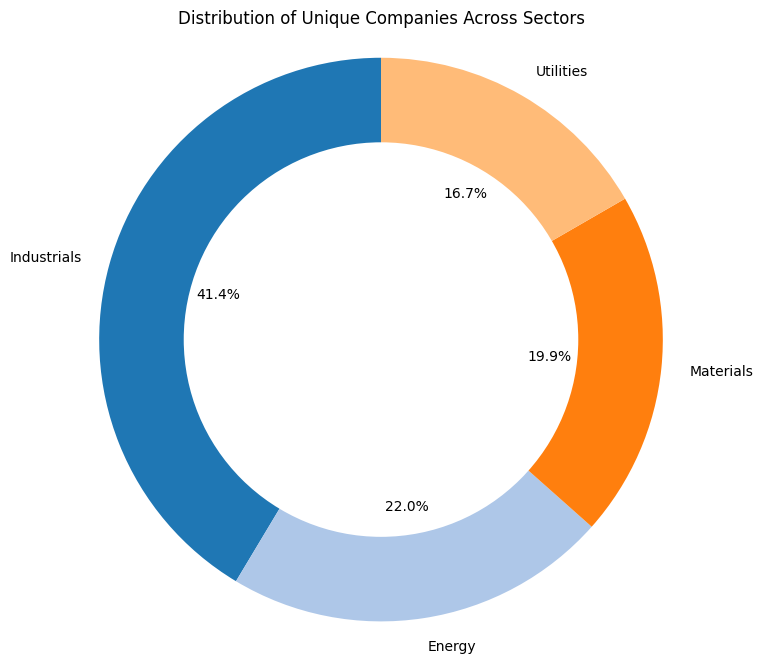

sector
Industrials    77
Energy         41
Materials      37
Utilities      31
Name: conm, dtype: int64


In [21]:
#Sector Distribution
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing the columns 'conm' (company name) and 'sector'
# Replace 'df' with the actual name of your DataFrame

# Grouping by 'sector' and counting unique company names
sector_company_counts = df_filtered_ticker.groupby('sector')['conm'].nunique()

# Sorting the counts in descending order for better visualization
sector_company_counts = sector_company_counts.sort_values(ascending=False)

# Create a dictionary to map sector codes to sector names
sector_mapping = {
    10: 'Energy',
    15: 'Materials',
    20: 'Industrials',
    55: 'Utilities'
}

# Replace sector codes with sector names
sector_company_counts.index = sector_company_counts.index.map(lambda x: sector_mapping[x] if x in sector_mapping else x)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 8))

# Create a pie chart
wedges, texts, autotexts = ax.pie(sector_company_counts, labels=sector_company_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.tab20.colors)

# Draw a circle in the center of pie to make it a donut
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Set title
plt.title('Distribution of Unique Companies Across Sectors')

# Show plot
plt.show()

print(sector_company_counts)


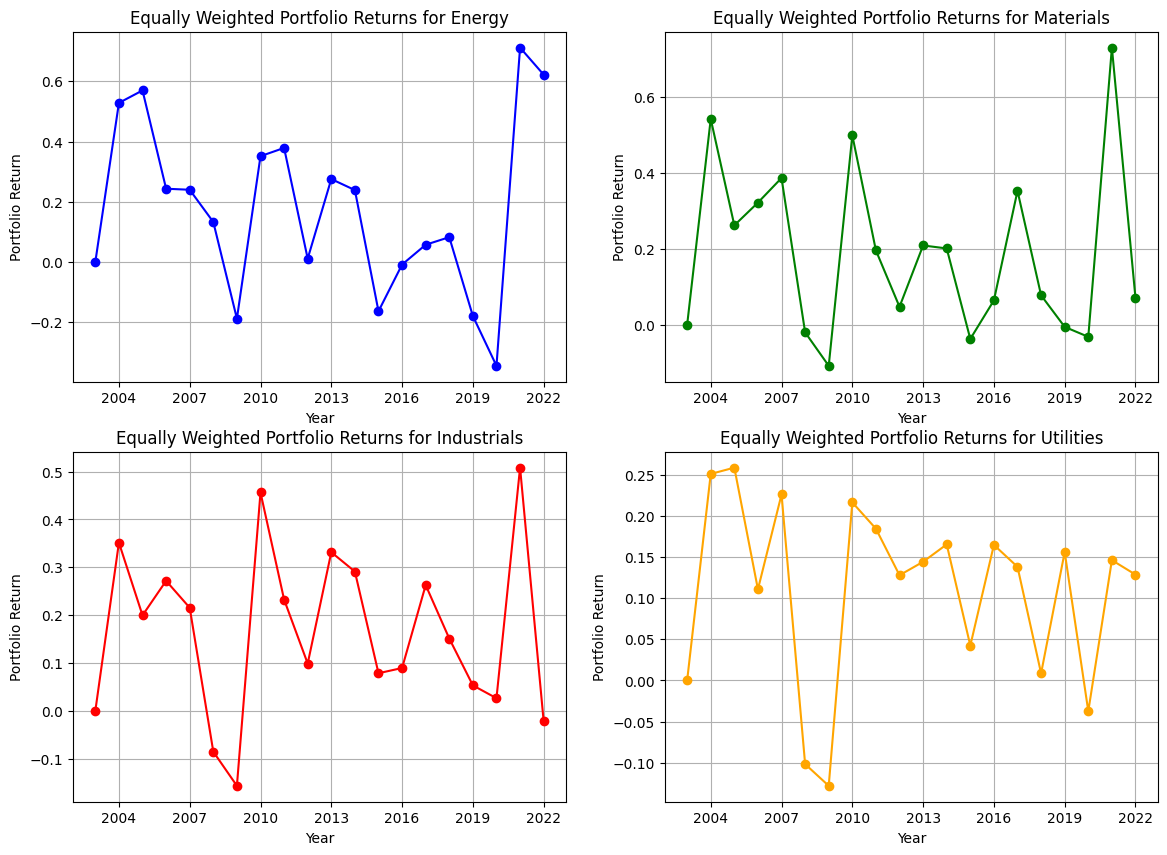

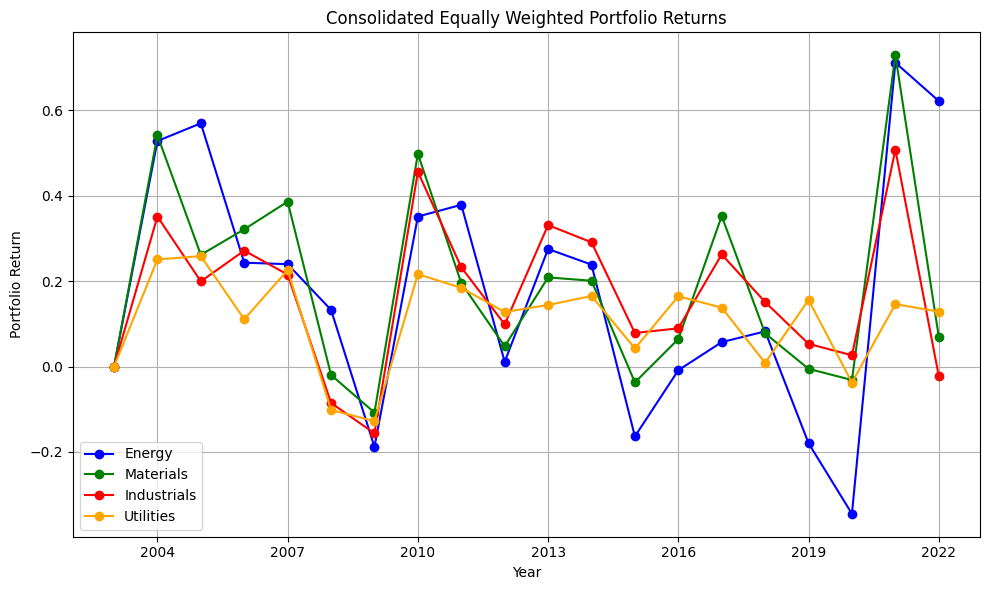

In [22]:
#Past 12 month returns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Assuming you have a DataFrame named 'final_df' containing company data with columns 'permno', 'return', 'sector', 'year', and 'past return 12m'

# Define a function to calculate the equally weighted portfolio return for a given sector
def calculate_portfolio_return(data):
    return (data['past return 12m'] * (1 / len(data))).sum()

# Create a dictionary to store sector names and colors
sector_info = {10: ('Energy', 'blue'), 15: ('Materials', 'green'), 20: ('Industrials', 'red'), 55: ('Utilities', 'orange')}

# Create subplots for individual sectors
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Create a consolidated plot
consolidated_fig, consolidated_ax = plt.subplots(figsize=(10, 6))

# Iterate over sectors
for sector, ax in zip([10, 15, 20, 55], axs.flatten()):
    # Filter data for the current sector
    sector_data = df_filtered_ticker[df_filtered_ticker['sector'] == sector]

    # Check if there is any data available for the current sector
    if not sector_data.empty:
        # Group by year and calculate the equally weighted portfolio return for each year
        portfolio_returns = sector_data.groupby('year').apply(calculate_portfolio_return)

        # Convert year index to integer
        portfolio_returns.index = portfolio_returns.index.astype(int)

        # Plot the portfolio returns with sector-specific color
        ax.plot(portfolio_returns.index, portfolio_returns.values, marker='o', linestyle='-', color=sector_info[sector][1])

        # Set plot title and labels
        ax.set_title(f'Equally Weighted Portfolio Returns for {sector_info[sector][0]}')
        ax.set_xlabel('Year')
        ax.set_ylabel('Portfolio Return')

        # Show grid
        ax.grid(True)

        # Set x-axis ticks to integer years without decimal points
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_major_formatter('{:.0f}'.format)

        # Add data to the consolidated plot
        consolidated_ax.plot(portfolio_returns.index, portfolio_returns.values, marker='o', linestyle='-', color=sector_info[sector][1], label=f'{sector_info[sector][0]}')
    else:
        # Hide the subplot if there is no data available for the current sector
        ax.axis('off')

# Set title and labels for the consolidated plot
consolidated_ax.set_title('Consolidated Equally Weighted Portfolio Returns')
consolidated_ax.set_xlabel('Year')
consolidated_ax.set_ylabel('Portfolio Return')

# Set x-axis ticks to integer years without decimal points for the consolidated plot
consolidated_ax.xaxis.set_major_locator(MaxNLocator(integer=True))
consolidated_ax.xaxis.set_major_formatter('{:.0f}'.format)

consolidated_ax.grid(True)
consolidated_ax.legend()

# Adjust layout for the consolidated plot
consolidated_fig.tight_layout()

# Show the plots
plt.show()


## Cleanup Column Naming and Duplications

In [23]:
for i in df_filtered_ticker.columns:
  if i[-2:] == '_y':
    df_filtered_ticker = df_filtered_ticker.drop(columns=i)
  elif i[-2:] == '_x':
    df_filtered_ticker.rename(columns={i:i[:-2]}, inplace=True)
  else:
    pass

df_filtered_ticker.columns


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['unnamed: 0', 'gvkey', 'permno', 'adate', 'qdate', 'public_date',
       'capei', 'bm', 'evm', 'pe_op_basic', 'pe_op_dil', 'pe_exi', 'pe_inc',
       'ps', 'pcf', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa',
       'roe', 'roce', 'aftret_eq', 'pretret_noa', 'pretret_earnat', 'gprof',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda',
       'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn',
       'pay_turn', 'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale',
       'accrual', 'ptb', 'ticker', 'cusip', 'conm', 'industry', 'sector',
       'public_month', 'permno', 'date', 'sic_industry_code', 'ticker',
       'comnam', 'cusip', 'volume', 'return', 'price index',
       'forward 1m return', 'forward 3m return', 'f

In [24]:
unique_columns = ~df_filtered_ticker.columns.duplicated(keep='first')
df_unique = df_filtered_ticker.loc[:, unique_columns]
df_unique.head()

,unnamed: 0,gvkey,permno,adate,qdate,public_date,capei,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip,conm,industry,sector,public_month,date,sic_industry_code,comnam,volume,return,price index,forward 1m return,forward 3m return,forward 6m return,forward 12m return,past return 1m,past return 12m,volatility,volatility adjusted forward 1m return,volatility adjusted forward 3m return,volatility adjusted forward 6m return,date_month,datadate,mcap,datadate_month,month,year
0,1,12136,10078,2002-06-30,2002-09-30,2003-01-31,11.925,1.154,48.234,-206.000,-206.000,-77.250,-77.250,0.797,13.542,-0.042,0.041,-0.043,0.487,-0.076,0.042,0.030,-0.052,-0.047,-0.052,-0.102,-0.053,0.366,0.899,0.134,0.147,0.131,0.359,0.077,0.336,0.096,3.120,0.703,0.213,0.106,0.153,0.131,0.412,2.727,0.149,0.412,0.182,0.702,0.510,1.431,1.550,0.751,4.967,6.596,1.150,1.278,0.145,0.01,-0.075,1.061,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-01,2003-01-31,3570.0,SUN MICROSYSTEMS INC,11399374.0,-0.006431,1.000000,0.113269,0.071197,0.216828,0.711003,-0.006431,NaN,NaN,NaN,NaN,NaN,2003-01,NaT,NaN,NaT,1,2003
1,2,12136,10078,2002-06-30,2002-12-31,2003-02-28,16.320,0.732,22.761,-57.333,-57.333,-18.595,-18.595,0.902,13.947,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.511,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-02,2003-02-28,3570.0,SUN MICROSYSTEMS INC,8671118.0,0.113269,1.113269,-0.052326,0.264533,0.133720,0.543604,0.113269,NaN,NaN,NaN,NaN,NaN,2003-02,NaT,NaN,NaT,2,2003
2,3,12136,10078,2002-06-30,2002-12-31,2003-03-31,15.635,0.732,22.761,-54.333,-54.333,-17.622,-17.622,0.864,13.361,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.448,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-03,2003-03-31,3570.0,SUN MICROSYSTEMS INC,10570497.0,-0.052326,1.055016,0.015337,0.426380,0.015337,0.279141,-0.052326,NaN,NaN,NaN,NaN,NaN,2003-03,NaT,NaN,NaT,3,2003
3,4,12136,10078,2002-06-30,2002-12-31,2003-04-30,15.874,0.732,22.761,-55.167,-55.167,-17.892,-17.892,0.877,13.566,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.470,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-04,2003-04-30,3570.0,SUN MICROSYSTEMS INC,10668815.0,0.015337,1.071197,0.314199,0.135952,0.193354,0.178249,0.015337,NaN,NaN,NaN,NaN,NaN,2003-04,NaT,NaN,NaT,4,2003
4,5,12136,10078,2002-06-30,2003-03-31,2003-05-31,26.985,0.699,16.357,-75.652,-75.652,-23.836,-23.836,1.183,15.983,-0.196,0.066,-0.014,0.505,-0.218,-0.117,0.050,-0.258,-0.015,-0.258,-0.032,-0.017,0.407,0.850,0.150,0.155,0.150,0.427,0.070,0.351,0.105,1.982,0.715,0.237,0.173,0.195,0.131,0.618,2.664,0.177,0.427,0.223,0.746,0.598,1.454,1.564,0.806,4.808,6.500,1.196,1.407,0.153,0.01,-0.212,1.909,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-05,2003-05-30,3570.0,SUN MICROSYSTEMS INC,13469662.0,0.314199,1.407766,0.068966,-0.103448,-0.020689,-0.041378,0.314199,NaN,NaN,NaN,NaN,NaN,2003-05,NaT,NaN,NaT,5,2003


In [25]:
df_filtered_ticker.tail()

,unnamed: 0,gvkey,permno,adate,qdate,public_date,capei,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip,conm,industry,sector,public_month,permno,date,sic_industry_code,ticker,comnam,cusip,volume,return,price index,forward 1m return,forward 3m return,forward 6m return,forward 12m return,past return 1m,past return 12m,volatility,volatility adjusted forward 1m return,volatility adjusted forward 3m return,volatility adjusted forward 6m return,date_month,gvkey,datadate,mcap,datadate_month,month,year
107205,124280,154357,93422,2019-12-31,2020-06-30,2020-10-31,-0.509,10.432,4.543,1.429,1.429,1.406,1.406,0.223,0.366,0.157,0.592,-0.003,0.678,0.211,0.758,0.103,0.050,-0.001,0.055,-0.001,0.000,0.118,0.605,0.395,0.436,0.395,0.030,NaN,0.459,0.363,3.529,0.163,0.662,1.272,1.312,0.201,0.165,0.548,0.584,0.497,0.443,0.988,0.183,0.643,1.002,0.174,4.674,NaN,0.209,0.345,0.0,0.0,-0.079,0.148,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-10,93422.0,2020-10-30,1311.0,QEP,Q E P RESOURCES INC,74733V10,596783.0,-0.003102,0.028501,0.788889,2.166668,NaN,NaN,-0.003102,-0.711818,2.274423,0.346852,0.952623,NaN,2020-10,NaN,NaT,NaN,NaT,10,2020
107206,124281,154357,93422,2019-12-31,2020-09-30,2020-11-30,-0.981,14.810,5.079,23.000,23.000,17.889,17.889,0.461,0.501,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.208,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-11,93422.0,2020-11-30,1311.0,QEP,Q E P RESOURCES INC,74733V10,950995.0,0.788889,0.050985,0.484472,1.136647,NaN,NaN,0.788889,-0.478206,2.367446,0.204639,0.480116,NaN,2020-11,NaN,NaT,NaN,NaT,11,2020
107207,124282,154357,93422,2019-12-31,2020-09-30,2020-12-31,-1.460,14.810,5.079,34.143,34.143,26.556,26.556,0.686,0.745,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.259,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-12,93422.0,2020-12-31,1311.0,QEP,Q E P RESOURCES INC,74733V10,1707010.0,0.484472,0.075685,0.192469,0.439332,NaN,NaN,0.484472,-0.437132,2.384453,0.080718,0.184248,NaN,2020-12,NaN,NaT,NaN,NaT,12,2020
107208,124283,154357,93422,2019-12-31,2020-09-30,2021-01-31,-1.741,14.810,5.079,40.714,40.714,31.667,31.667,0.818,0.889,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.308,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2021-01,93422.0,2021-01-29,1311.0,QEP,Q E P RESOURCES INC,74733V10,951507.0,0.192469,0.090252,0.207018,NaN,NaN,NaN,0.192469,-0.047188,2.375389,0.087151,NaN,NaN,2021-01,NaN,NaT,NaN,NaT,1,2021
107209,124284,154357,93422,2020-12-31,2020-12-31,2021-02-28,-2.004,5.270,6.189,-86.000,-86.000,344.000,344.000,1.152,1.239,0.004,0.497,-0.308,0.623,-0.106,0.815,0.068,0.001,-0.049,0.001,-0.045,-0.043,0.088,0.622,0.378,0.384,0.378,0.025,NaN,0.621,0.322,4.577,0.123,0.664,1.201,2.247,0.275,0.469,0.506,0.531,0.478,0.403,0.915,0.202,0.610,0.658,0.137,5.404,NaN,0.169,0.271,0.0,0.0,-0.127,0.392,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2021-02,93422.0,2021-02-26,1311.0,QEP,Q E P RESOURCES INC,74733V10,640639.0,0.207018,0.108936,NaN,NaN,NaN,NaN,0.207018

In [26]:
df_unique.tail()

,unnamed: 0,gvkey,permno,adate,qdate,public_date,capei,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip,conm,industry,sector,public_month,date,sic_industry_code,comnam,volume,return,price index,forward 1m return,forward 3m return,forward 6m return,forward 12m return,past return 1m,past return 12m,volatility,volatility adjusted forward 1m return,volatility adjusted forward 3m return,volatility adjusted forward 6m return,date_month,datadate,mcap,datadate_month,month,year
107205,124280,154357,93422,2019-12-31,2020-06-30,2020-10-31,-0.509,10.432,4.543,1.429,1.429,1.406,1.406,0.223,0.366,0.157,0.592,-0.003,0.678,0.211,0.758,0.103,0.050,-0.001,0.055,-0.001,0.000,0.118,0.605,0.395,0.436,0.395,0.030,NaN,0.459,0.363,3.529,0.163,0.662,1.272,1.312,0.201,0.165,0.548,0.584,0.497,0.443,0.988,0.183,0.643,1.002,0.174,4.674,NaN,0.209,0.345,0.0,0.0,-0.079,0.148,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-10,2020-10-30,1311.0,Q E P RESOURCES INC,596783.0,-0.003102,0.028501,0.788889,2.166668,NaN,NaN,-0.003102,-0.711818,2.274423,0.346852,0.952623,NaN,2020-10,NaT,NaN,NaT,10,2020
107206,124281,154357,93422,2019-12-31,2020-09-30,2020-11-30,-0.981,14.810,5.079,23.000,23.000,17.889,17.889,0.461,0.501,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.208,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-11,2020-11-30,1311.0,Q E P RESOURCES INC,950995.0,0.788889,0.050985,0.484472,1.136647,NaN,NaN,0.788889,-0.478206,2.367446,0.204639,0.480116,NaN,2020-11,NaT,NaN,NaT,11,2020
107207,124282,154357,93422,2019-12-31,2020-09-30,2020-12-31,-1.460,14.810,5.079,34.143,34.143,26.556,26.556,0.686,0.745,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.259,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2020-12,2020-12-31,1311.0,Q E P RESOURCES INC,1707010.0,0.484472,0.075685,0.192469,0.439332,NaN,NaN,0.484472,-0.437132,2.384453,0.080718,0.184248,NaN,2020-12,NaT,NaN,NaT,12,2020
107208,124283,154357,93422,2019-12-31,2020-09-30,2021-01-31,-1.741,14.810,5.079,40.714,40.714,31.667,31.667,0.818,0.889,0.028,0.543,-0.129,0.645,-0.008,0.706,0.082,0.007,-0.023,0.008,-0.021,-0.020,0.099,0.620,0.380,0.419,0.380,0.023,NaN,0.465,0.346,4.164,0.159,0.643,1.069,1.812,0.201,0.504,0.536,0.537,0.488,0.427,0.954,0.145,0.604,0.988,0.153,4.285,NaN,0.185,0.299,0.0,0.0,-0.136,0.308,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2021-01,2021-01-29,1311.0,Q E P RESOURCES INC,951507.0,0.192469,0.090252,0.207018,NaN,NaN,NaN,0.192469,-0.047188,2.375389,0.087151,NaN,NaN,2021-01,NaT,NaN,NaT,1,2021
107209,124284,154357,93422,2020-12-31,2020-12-31,2021-02-28,-2.004,5.270,6.189,-86.000,-86.000,344.000,344.000,1.152,1.239,0.004,0.497,-0.308,0.623,-0.106,0.815,0.068,0.001,-0.049,0.001,-0.045,-0.043,0.088,0.622,0.378,0.384,0.378,0.025,NaN,0.621,0.322,4.577,0.123,0.664,1.201,2.247,0.275,0.469,0.506,0.531,0.478,0.403,0.915,0.202,0.610,0.658,0.137,5.404,NaN,0.169,0.271,0.0,0.0,-0.127,0.392,QEP,74733V10,QEP RESOURCES INC,101020.0,10.0,2021-02,2021-02-26,1311.0,Q E P RESOURCES INC,640639.0,0.207018,0.108936,NaN,NaN,NaN,NaN,0.207018,0.620308,2.327642,NaN,NaN,NaN,2021-02,NaT,NaN,NaT,2,2021


In [27]:
dec_df2 = df_filtered_ticker[df_filtered_ticker['public_date'] == ('2022-12-31')]

print(dec_df2.shape)

dec_mon= df_unique[df_unique['public_date'] == ('2022-12-31')]
print(dec_mon.shape)


(135, 92)
(135, 88)


## Encode Label Column

This is set up as a binary classification

In [28]:
public_months = list(df_unique['public_month'].unique())

def assign_label(x, upper_thres):
    return 1 if x >= upper_thres else 0

def calculate_thresholds(data):
    upper_thres = np.percentile(data, 70)
    lower_thres = np.percentile(data, 30)
    return upper_thres, lower_thres

for month in public_months:
    # Filter data for the current month and remove rows with null 'forward 3m return'
    monthly_data = df_unique.loc[(df_unique['public_month'] == month) & (df_unique['forward 3m return'].notnull())]['forward 3m return'].values

    if len(monthly_data) > 0:
        upper_thres, _ = calculate_thresholds(monthly_data)

        # Apply the assign_label function to the 'forward 3m return' array for the current month
        df_unique.loc[(df_unique['public_month'] == month) & (df_unique['forward 3m return'].notnull()), 'label'] = \
            np.vectorize(lambda x: assign_label(x, upper_thres))(monthly_data)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [29]:
drop_cols = ['unnamed: 0', 'adate', 'qdate', 'public_date',
        'date','forward 1m return', 'forward 3m return', 'forward 6m return',
       'forward 12m return',
       'volatility adjusted forward 1m return',
       'volatility adjusted forward 3m return',
       'volatility adjusted forward 6m return', 'date_month', 'gvkey',
       'datadate', 'datadate_month']

df_unique = df_unique.drop(columns=drop_cols)

final_df = df_unique.loc[df_unique['label'].notnull()].copy()

assert len(final_df) == len(df_unique)-511

In [30]:
final_df.isnull().sum()

permno                   0
capei                  200
bm                     521
evm                     14
pe_op_basic            225
pe_op_dil              226
pe_exi                 223
pe_inc                 207
ps                      14
pcf                     38
npm                     14
opmbd                   14
opmad                   14
gpm                     14
ptpm                    14
cfm                     39
roa                     41
roe                    564
roce                   131
aftret_eq               41
pretret_noa            175
pretret_earnat         175
gprof                   14
equity_invcap           18
debt_invcap             78
totdebt_invcap          96
capital_ratio           71
cash_lt                 35
invt_act               552
rect_act               139
debt_at                 89
debt_ebitda             92
curr_debt              163
lt_debt                 71
profit_lct             142
ocf_lct                166
cash_debt              211
f

In [31]:
# Make sure there are around 40+ labelled 1
final_df[['public_month','label','permno']].groupby(['public_month','label']).count()

permno
public_month label        
2003-01      0.0       110
             1.0        48
2003-02      0.0       110
             1.0        48
2003-03      0.0       110
             1.0        48
2003-04      0.0       110
             1.0        48
2003-05      0.0       110
             1.0        48
2003-06      0.0       110
             1.0        48
2003-07      0.0       110
             1.0        48
2003-08      0.0       110
             1.0        48
2003-09      0.0       110
             1.0        48
2003-10      0.0       110
             1.0        48
2003-11      0.0       110
             1.0        48
2003-12      0.0       110
             1.0        47
2004-01      0.0       110
             1.0        47
2004-02      0.0       110
             1.0        47
2004-03      0.0       110
             1.0        47
2004-04      0.0       110
             1.0        47
2004-05      0.0       110
             1.0        48
2004-06      0.0       110
             1.0        48
2004-07      0.0       110
             1.0        47
2004-08      0.0       110
             1.0        47
2004-09      0.0       110
             1.0        47
2004-10      0.0       110
             1.0        47
2004-11      0.0       110
             1.0        47
2004-12      0.0       110
             1.0        48
2005-01      0.0       110
             1.0        48
2005-02      0.0       110
             1.0        47
2005-03      0.0       110
             1.0        48
2005-04      0.0       110
             1.0        48
2005-05      0.0       110
             1.0        48
2005-06      0.0       110
             1.0        48
2005-07      0.0       110
             1.0        48
2005-08      0.0       109
             1.0        47
2005-09      0.0       109
             1.0        47
2005-10      0.0       109
             1.0        47
2005-11      0.0       109
             1.0        47
2005-12      0.0       109
             1.0        47
2006-01      0.0       109
             1.0        47
2006-02      0.0       108
             1.0        47
2006-03      0.0       109
             1.0        47
2006-04      0.0       109
             1.0        47
2006-05      0.0       110
             1.0        47
2006-06      0.0       109
             1.0        47
2006-07      0.0       109
             1.0        47
2006-08      0.0       109
             1.0        47
2006-09      0.0       109
             1.0        47
2006-10      0.0       109
             1.0        47
2006-11      0.0       109
             1.0        47
2006-12      0.0       109
             1.0        47
2007-01      0.0       109
             1.0        47
2007-02      0.0       109
             1.0        47
2007-03      0.0       109
             1.0        47
2007-04      0.0       109
             1.0        47
2007-05      0.0       109
             1.0        47
2007-06      0.0       109
             1.0        47
2007-07      0.0       109
             1.0        47
2007-08      0.0       109
             1.0        47
2007-09      0.0       109
             1.0        47
2007-10      0.0       110
             1.0        47
2007-11      0.0       110
             1.0        47
2007-12      0.0       110
             1.0        47
2008-01      0.0       110
             1.0        47
2008-02      0.0       110
             1.0        47
2008-03      0.0       110
             1.0        47
2008-04      0.0       109
             1.0        47
2008-05      0.0       109
             1.0        47
2008-06      0.0       109
             1.0        47
2008-07      0.0       109
             1.0        47
2008-08      0.0       109
             1.0        47
2008-09      0.0       108
             1.0        46
2008-10      0.0       108
             1.0        46
2008-11      0.0       108
             1.0        46
2008-12      0.0       108
             1.0        46
2009-01      0.0       108
             1.0        46
2009-02      0.0       1

## Feature Engineering
1. Extract month from public date
2. Extract year from public date
3. Check for autocorrelation

In [32]:
def extract_month(x):
    """
    Extracts month from public date
    """
    if pd.api.types.is_datetime64_any_dtype(x):
        return x.month
    else:
        dt = x.to_timestamp()
        return dt.month

def extract_year(x):
    """
    Extracts year from public date
    """
    if pd.api.types.is_datetime64_any_dtype(x):
        return x.year
    else:
        dt = x.to_timestamp()
        return dt.year

final_df['month'] = final_df['public_month'].apply(extract_month)
final_df['year'] = final_df['public_month'].apply(extract_year)

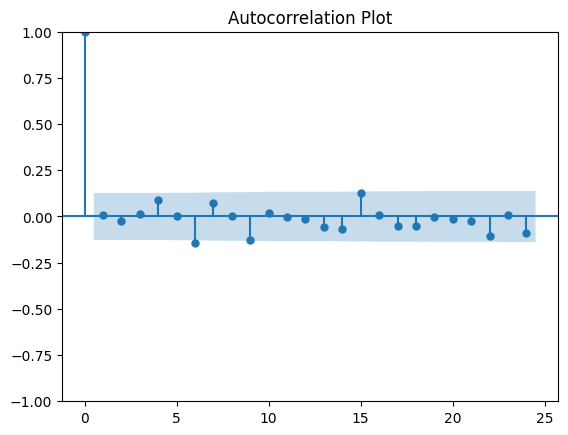

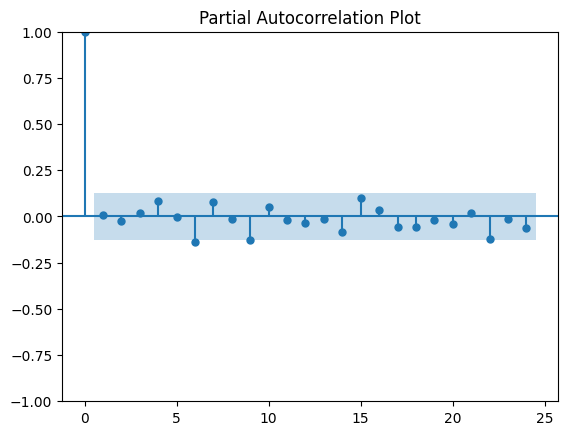

In [33]:
# No autocorrelation/partial autocorrelation - so no need to create autoregressive terms in the dataset
auto_corr = final_df[['public_month','return']].groupby('public_month')['return'].mean()

plot_acf(auto_corr)
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(auto_corr)
plt.title('Partial Autocorrelation Plot')
plt.show()

## Basic EDA (Part 2)
1. Boxplot return by year
2. Boxplot return by month
3. Correlation plot

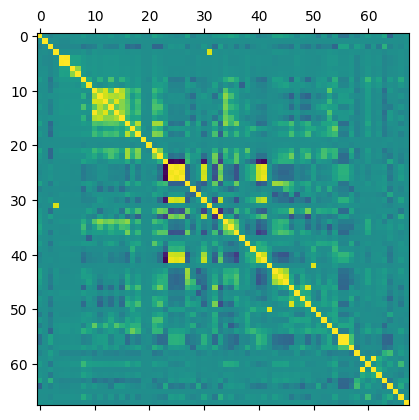

In [34]:
# Visualize correlation
correlation_matrix = final_df.corr(numeric_only=True)

plt.matshow(correlation_matrix)
plt.show()

In [35]:
# Get pair for features that are highly correlation indicating they may be redundant

threshold = 0.98

correlation_pairs = []

correlation_pairs = [
    (col1, col2)
    for col1, col2 in combinations(correlation_matrix.columns, 2)
    if abs(correlation_matrix.loc[col1, col2]) > threshold
]

print("Pairs with correlation above the threshold:")
for pair in correlation_pairs:
    print(pair)

Pairs with correlation above the threshold:
('pe_op_basic', 'pe_op_dil')
('equity_invcap', 'capital_ratio')
('debt_invcap', 'capital_ratio')
('industry', 'sector')
('return', 'past return 1m')


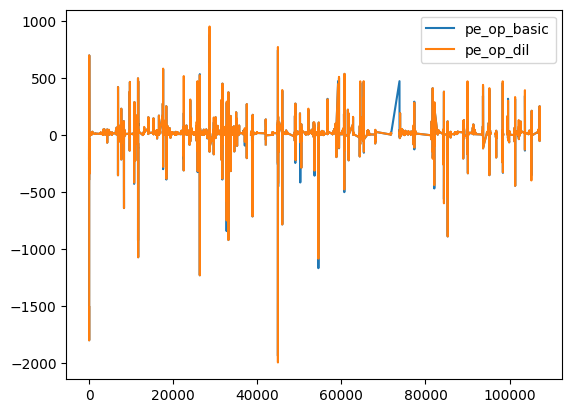

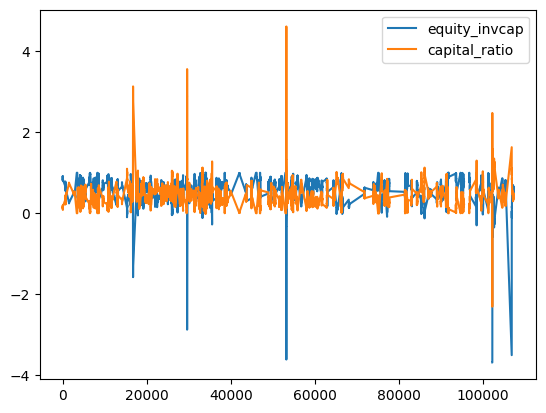

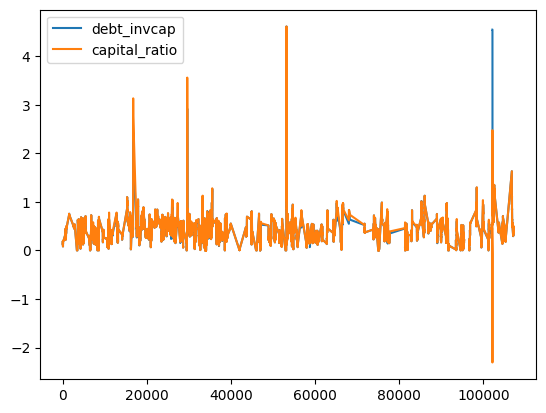

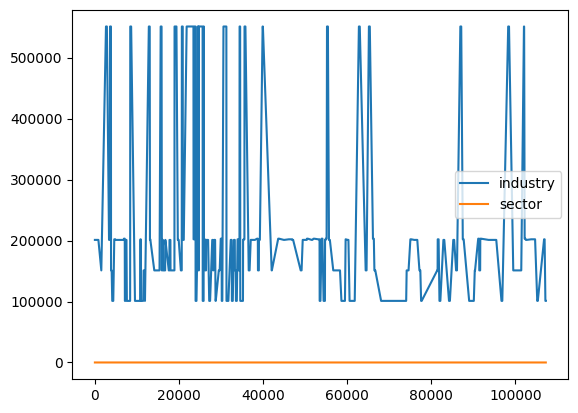

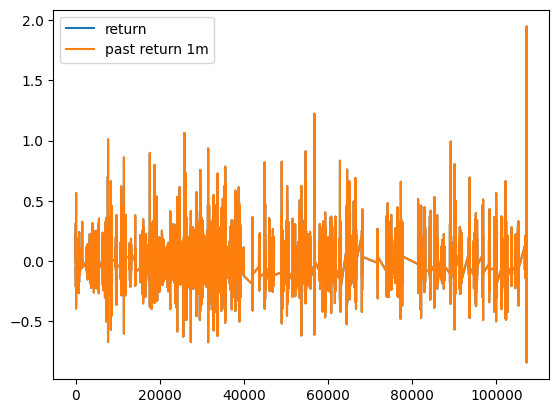

In [36]:
# Visualize the highly correlation feature pairs to determine which we want to drop
for pair in correlation_pairs:
  final_df[[pair[0],pair[1]]].plot()

In [37]:
#drop duplicate columns
final_df = final_df.drop(columns=['pe_op_dil','past return 1m'])

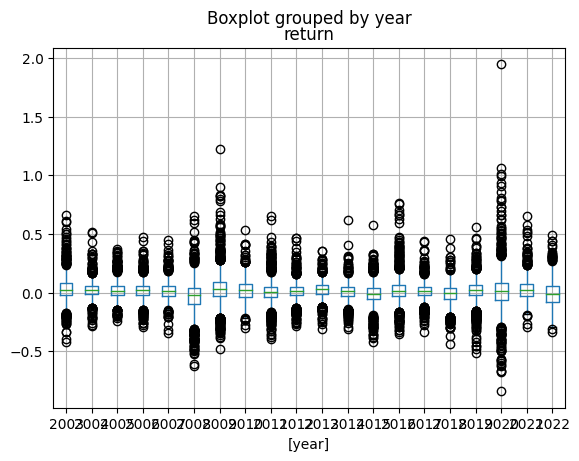

In [38]:
# Visualize boxplot of return by year
boxplot = final_df[['year','return']].boxplot(by='year')

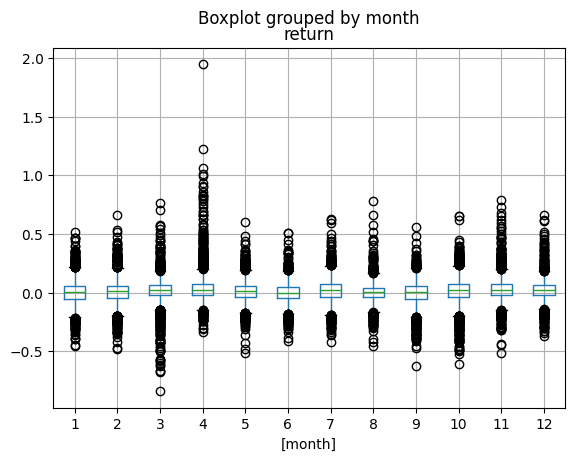

In [39]:
# Visualize boxplot of return by month - to help indicate if we observe some sort of seasonal component
boxplot = final_df[['month','return']].boxplot(by='month')

In [40]:
cols = ['capei', 'bm', 'evm', 'pe_op_basic', 'pe_exi', 'pe_inc', 'ps',
        'pcf', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
        'roce', 'aftret_eq', 'pretret_noa', 'pretret_earnat', 'gprof',
        'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
        'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda',
        'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf',
        'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
        'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn',
        'pay_turn', 'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale',
        'accrual', 'ptb', 'return','price index', 'past return 12m',
        'volatility']

#,'volume', 'mcap' -we expect to see significant outliers here as both volume and mcap can significantly deviate

final_df[cols].describe()

,capei,bm,evm,pe_op_basic,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,return,price index,past return 12m,volatility
count,35260.000000,34939.000000,35446.000000,35235.000000,35237.000000,35253.000000,35446.000000,35422.000000,35446.000000,35446.000000,35446.000000,35446.000000,35446.000000,35421.000000,35419.000000,34896.000000,35329.000000,35419.000000,35285.000000,35285.000000,35446.000000,35442.000000,35382.000000,35364.000000,35389.000000,35425.000000,34908.000000,35321.000000,35371.000000,35368.000000,35297.000000,35389.000000,35318.000000,35294.000000,35249.000000,35039.000000,35425.000000,34930.000000,35425.000000,35336.000000,35425.000000,35321.000000,35321.000000,35321.000000,35419.000000,35419.000000,34814.000000,35439.000000,34924.000000,35451.000000,35445.000000,35422.000000,34939.000000,35460.000000,35460.000000,33317.000000,33317.000000
mean,31.717419,0.576802,9.799536,16.436950,15.126352,15.020460,1.987156,11.709244,0.066392,0.227419,0.138275,0.334955,0.099349,0.161808,0.144230,0.149851,0.162620,0.156383,0.146638,0.163053,0.235899,0.561946,0.418365,0.472331,0.426071,0.131358,0.225792,0.401999,0.291694,2.245479,0.323715,0.401981,0.894667,0.710842,0.196049,0.130180,2.865840,1.014711,0.626803,0.501339,3.100678,0.389580,1.154080,1.549717,0.796980,8.669746,9.357022,1.355225,3.922231,0.009116,0.003067,-0.054370,3.298159,0.013388,4.912455,0.173096,0.288812
std,1259.456706,0.599655,73.540788,55.350939,71.246095,68.079127,1.892013,18.804129,0.191859,0.192540,0.223366,0.195947,0.254614,0.173867,0.084487,0.387369,0.159256,8.866744,9.064208,0.156153,0.181985,0.254817,0.241035,0.280817,0.251670,0.196099,0.152389,0.161259,0.150358,27.796140,0.181647,0.168836,0.710911,0.540846,0.174756,7.199247,4.133212,3.856228,0.166006,0.221978,64.499458,0.440066,0.590815,0.860352,0.566451,6.358717,6.099536,1.177317,39.906380,0.017646,0.010573,0.063116,4.529152,0.098054,6.370380,0.416086,0.171267
min,-67340.000000,0.001000,-5269.200000,-1937.000000,-3000.000000,-2606.500000,0.019000,-394.960000,-10.309000,-6.423000,-12.233000,-2.505000,-14.130000,-4.226000,-1.009000,-5.067000,-3.560000,-683.040000,-769.520000,-1.120000,-2.529000,-3.685000,0.000000,0.000000,-2.307000,0.000000,0.000000,0.002000,0.000000,-1825.200000,0.040000,0.000000,-8.573000,-1.552000,-0.545000,-538.400000,0.238000,0.000000,0.091000,-6.121000,-1760.700000,0.000000,0.180000,0.204000,0.011000,0.100000,-0.265000,0.014000,0.022000,0.000000,0.000000,-1.104000,0.080000,-0.842444,0.010593,-0.981358,0.022835
25%,14.714000,0.280000,7.522000,10.444500,9.720000,9.294000,0.916000,6.277000,0.040000,0.139000,0.090000,0.226000,0.058000,0.093000,0.093000,0.063000,0.087000,0.078000,0.089000,0.073000,0.111000,0.436000,0.267000,0.304000,0.271000,0.028000,0.092000,0.299000,0.193000,1.125000,0.186000,0.303000,0.501000,0.357000,0.096000,0.047000,0.956000,0.331000,0.519000,0.370000,1.063000,0.114000,0.771000,0.989000,0.368000,5.694000,5.755000,0.572000,1.090000,0.000000,0.000000,-0.074000,1.339000,-0.034812,1.659981,-0.040808,0.177410
50%,21.776000,0.475000,9.619000,16.273000,16.568000,16.204000,1.464000,9.475000,0.078000,0.200000,0.140000,0.323000,0.111000,0.141000,0.132000,0.120500,0.141000,0.146000,0.181000,0.133000,0.204000,0.568000,0.413000,0.456000,0.420000,0.074000,0.220000,0.392000,0.286000,2.195500,0.285000,0.419000,0.750500,0.562000,0.154000,0.463000,1.441000,0.593000,0.634000,0.497000,1.731000,0.266000,1.034000,1.359000,0.683000,7.251000,8.145000,1.052000,1.865000,0.000000,0.000000,-0.045000,2.178000,0.013780,2.919053,0.144057,0.247755
75%,32.158500,0.761000,12.311000,22.601000,23.943000,23.775000,2.462000,14.8

In [41]:
# Identify extreme values
def compute_outlier_thres(data, col):
  """
    Compute upper and lower thresholds for outlier detection using the IQR method.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - col (str): The column name for which outlier thresholds are to be computed.

    Returns:
    tuple: A tuple containing the upper and lower thresholds for outlier detection.
  """
  values = data.loc[data[col].notnull(), col]

  q1, q3 = np.percentile(values, [25, 75])
  iqr = q3 - q1
  upper_thres = q3 + (1.5 * iqr)
  lower_thres = q1 - (1.5 * iqr)

  return upper_thres, lower_thres



for col in cols:
  upper, lower = compute_outlier_thres(final_df, col)
  final_df['outlier_'+col] = [True if i >= upper or i <= lower else False for i in final_df[col]]
  outlier_count = final_df['outlier_'+col].sum()
  print(f'{col}: {outlier_count}')

# Decide what to do, if anything, about extreme values. I do not see a strong case for removal

capei: 4738
bm: 1044
evm: 2437
pe_op_basic: 3916
pe_exi: 4442
pe_inc: 4453
ps: 2171
pcf: 2146
npm: 3548
opmbd: 1850
opmad: 2664
gpm: 1249
ptpm: 3526
cfm: 2943
roa: 1271
roe: 2941
roce: 2001
aftret_eq: 3704
pretret_noa: 2291
pretret_earnat: 1652
gprof: 1790
equity_invcap: 611
debt_invcap: 614
totdebt_invcap: 621
capital_ratio: 718
cash_lt: 2249
invt_act: 42
rect_act: 634
debt_at: 427
debt_ebitda: 1366
curr_debt: 1470
lt_debt: 218
profit_lct: 2366
ocf_lct: 2039
cash_debt: 2110
fcf_ocf: 1137
lt_ppent: 2007
dltt_be: 2774
debt_assets: 645
debt_capital: 776
de_ratio: 3136
cash_ratio: 2105
quick_ratio: 1854
curr_ratio: 1552
at_turn: 1425
rect_turn: 2900
pay_turn: 1784
sale_invcap: 1832
sale_equity: 2480
rd_sale: 2600
adv_sale: 35445
accrual: 2528
ptb: 2530
return: 1961
price index: 2969
past return 12m: 1816
volatility: 1729


## Build XGBoost Model on Cleaned Dataset


In [42]:
numerical_cols = [cname for cname in final_df.columns if final_df[cname].dtype in ['int64', 'float64']]

train = final_df.loc[final_df['public_month'] <= pd.Period('2022-08', 'M')][numerical_cols]
test = final_df.loc[final_df['public_month'] == pd.Period('2022-09', 'M')][numerical_cols]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)

print("AUC-ROC Score:", auc_roc)

AUC-ROC Score: 0.7311883757135443


In [43]:
X_train.columns

Index(['permno', 'capei', 'bm', 'evm', 'pe_op_basic', 'pe_exi', 'pe_inc', 'ps',
       'pcf', 'npm', 'opmbd', 'opmad', 'gpm', 'ptpm', 'cfm', 'roa', 'roe',
       'roce', 'aftret_eq', 'pretret_noa', 'pretret_earnat', 'gprof',
       'equity_invcap', 'debt_invcap', 'totdebt_invcap', 'capital_ratio',
       'cash_lt', 'invt_act', 'rect_act', 'debt_at', 'debt_ebitda',
       'curr_debt', 'lt_debt', 'profit_lct', 'ocf_lct', 'cash_debt', 'fcf_ocf',
       'lt_ppent', 'dltt_be', 'debt_assets', 'debt_capital', 'de_ratio',
       'cash_ratio', 'quick_ratio', 'curr_ratio', 'at_turn', 'rect_turn',
       'pay_turn', 'sale_invcap', 'sale_equity', 'rd_sale', 'adv_sale',
       'accrual', 'ptb', 'industry', 'sector', 'sic_industry_code', 'volume',
       'return', 'price index', 'past return 12m', 'volatility', 'mcap',
       'month', 'year'],
      dtype='object')

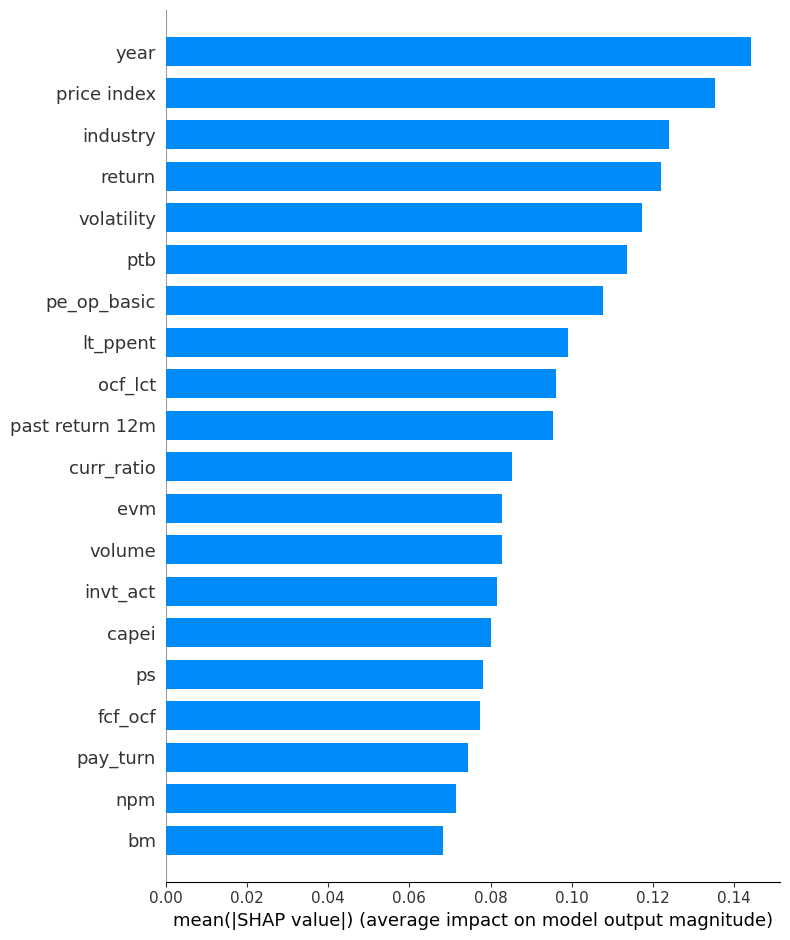

In [44]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

shap.summary_plot(shap_values, X_test, plot_type="bar")

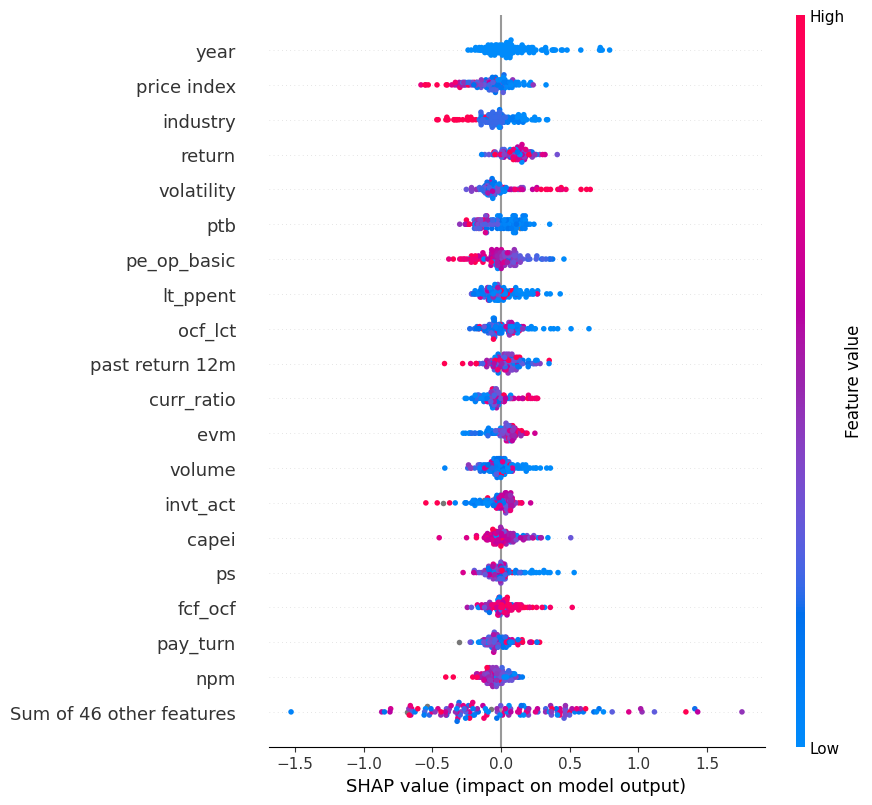

In [45]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

## Cross Validate, Hyperparameter Tuning & Lookback Window

* Lookback windows tested: 3,6,12,18,24,36,48 months
* Current best window 36 months:
  * Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 1000}
  * Best AUC Score:  0.7621691748832383


In [ ]:
# Potential Lookback Windows
lookback_windows = [36] #[3, 6, 12,18, 24, 36, 48]

# Param Grid for GridSearch
params = {
    'model__n_estimators':[ 1000],
    'model__max_depth': [15],
    'model__learning_rate': [0.25]
}


# Assign Label and Features
model_df = final_df.copy().reset_index(drop=True)
X = model_df[numerical_cols].drop(columns=['label'])
y = model_df['label']


#Custom Functions to Control Train/Test Splits

def compute_window_indices(lookback_months, prediction_month, steps=1):
  """
    Compute train and test indices for a time-based window.

    Parameters:
    - lookback_months (int or 'All'): Number of months to look back for training data.
      Set to 'All' to use all available data.
    - prediction_month (int): Month for which predictions are made.
      If provided, the lookback window ends at prediction_month - 1.

    Returns:
    - train_idx (pd.Index): Index of training data in the DataFrame.
    - test_idx (pd.Index): Index of test data in the DataFrame.

    Example:
    train_idx, test_idx = compute_window_indices(3, prediction_month=12)
  """
  lookback_end = prediction_month - steps

  if lookback_months == 'All':
    lookback_start = min(model_df['public_month'])
  else:
    lookback_start = prediction_month - lookback_months

  train_idx = model_df.loc[(model_df['public_month'] >= lookback_start) & (model_df['public_month'] <= lookback_end)].index
  test_idx = model_df.loc[model_df['public_month'] == prediction_month].index

  return pd.Index(train_idx, dtype="int64"), pd.Index(test_idx, dtype="int64")


def custom_split(first_prediction_month, folds, lookback_months, steps=1):
  """
    Generate train and test indices for a specified number of folds using a custom time-based window.

    Parameters:
    - first_prediction_month (int): The first month for which predictions will be made.
    - folds (int): The number of folds for cross-validation.
    - lookback_months (int or 'All'): Number of months to look back for training data.
      Set to 'All' to use all available data.

    Returns:
    - zipped (zip): A zip object containing pairs of train and test indices for each fold.

    Example:
    ```
    # Generate custom split with 5 folds, looking back 3 months, starting from prediction month 12
    custom_split_result = custom_split(first_prediction_month=12, folds=5, lookback_months=3)

    for train_idx, test_idx in custom_split_result:
        # Use train_idx and test_idx for training and testing in each fold
        print(f"Train indices: {train_idx}, Test indices: {test_idx}")
    ```
  """

  train_indices = []
  test_indices = []

  prediction_month = first_prediction_month

  for i in range(1,folds + 1):
    train_idx, test_idx = compute_window_indices(lookback_months,prediction_month,steps)
    train_indices.append(train_idx)
    test_indices.append(test_idx)

    prediction_month -= 1

  return zip(train_indices, test_indices)



# Recreate Pipeline Stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X.columns),
    ])

model = xgb.XGBClassifier()

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

folds = 5

#Perform GridSearchCV for each lookback window
for i in lookback_windows:
  print('-' * 30)
  print(f'Lookback Window: {i} months')
  print('-' * 30)

  tscv = custom_split(pd.Period('2022-09', 'M'), folds, i)
  grid_search = GridSearchCV(pipe, param_grid=params, scoring='roc_auc', cv=tscv, verbose=5)
  grid_search_result = grid_search.fit(X, y)

  print("Best Parameters: ", grid_search_result.best_params_)
  print("Best AUC Score: ", grid_search_result.best_score_)

'''
------------------------------
Lookback Window: 3 months
------------------------------
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 500}
Best AUC Score:  0.711572392319668
------------------------------
Lookback Window: 6 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__n_estimators': 500}
Best AUC Score:  0.7444213803840165
------------------------------
Lookback Window: 12 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 1000}
Best AUC Score:  0.7580176440062274
------------------------------
Lookback Window: 18 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.5, 'model__max_depth': 15, 'model__n_estimators': 500}
Best AUC Score:  0.7566683964711988
------------------------------
Lookback Window: 24 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 25, 'model__n_estimators': 500}
Best AUC Score:  0.7589517384535547
------------------------------
Lookback Window: 36 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 1000}
Best AUC Score:  0.7621691748832383
------------------------------
Lookback Window: 48 months
------------------------------
Best Parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 15, 'model__n_estimators': 1000}
Best AUC Score:  0.7491437467566164
'''

------------------------------
Lookback Window: 36 months
------------------------------
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END model__learning_rate=0.25, model__max_depth=15, model__n_estimators=1000;, score=0.828 total time=  12.6s
[CV 2/5] END model__learning_rate=0.25, model__max_depth=15, model__n_estimators=1000;, score=0.789 total time=  12.6s
[CV 3/5] END model__learning_rate=0.25, model__max_depth=15, model__n_estimators=1000;, score=0.733 total time=  12.8s
[CV 4/5] END model__learning_rate=0.25, model__max_depth=15, model__n_estimators=1000;, score=0.717 total time=  14.5s
[CV 5/5] END model__learning_rate=0.25, model__max_depth=15, model__n_estimators=1000;, score=0.738 total time=  12.7s
Best Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 1000}
Best AUC Score:  0.7610793980280228


"\n------------------------------\nLookback Window: 3 months\n------------------------------\nFitting 5 folds for each of 18 candidates, totalling 90 fits\nBest Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 500}\nBest AUC Score:  0.711572392319668\n------------------------------\nLookback Window: 6 months\n------------------------------\nBest Parameters:  {'model__learning_rate': 0.1, 'model__max_depth': 20, 'model__n_estimators': 500}\nBest AUC Score:  0.7444213803840165\n------------------------------\nLookback Window: 12 months\n------------------------------\nBest Parameters:  {'model__learning_rate': 0.25, 'model__max_depth': 15, 'model__n_estimators': 1000}\nBest AUC Score:  0.7580176440062274\n------------------------------\nLookback Window: 18 months\n------------------------------\nBest Parameters:  {'model__learning_rate': 0.5, 'model__max_depth': 15, 'model__n_estimators': 500}\nBest AUC Score:  0.7566683964711988\n---------------

## Observe Best Model Performance Across Time

* Given the best performing lookback window is 3 years, we can divide the dataset into 6 segments (2003-2005, 2006-2008, 2009-2011, 2012-2014,2015-2017,2018-2020)
* For each segment we will do a 3 step forward projection to mirror the conditions of our final prediction (3 step because we will only have labelled date up to 2022-09 and we need to predict 2022-12)
* We will compare model performance (AUC, F1) and feature importance

In [46]:
segments = []
end = pd.Period('2021-09','M')
for i in range(6):
  start = end - 35
  dates = [start,end]
  segments.append(dates)
  end -= 36

segments

[[Period('2018-10', 'M'), Period('2021-09', 'M')],
 [Period('2015-10', 'M'), Period('2018-09', 'M')],
 [Period('2012-10', 'M'), Period('2015-09', 'M')],
 [Period('2009-10', 'M'), Period('2012-09', 'M')],
 [Period('2006-10', 'M'), Period('2009-09', 'M')],
 [Period('2003-10', 'M'), Period('2006-09', 'M')]]

### Segment 1: 2003-10 to 2006-09


In [47]:
train = final_df.loc[(final_df['public_month'] >= segments[5][0])&(final_df['public_month'] <= segments[5][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[5][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.6511809486628928
F1 Score:: 0.2608695652173913


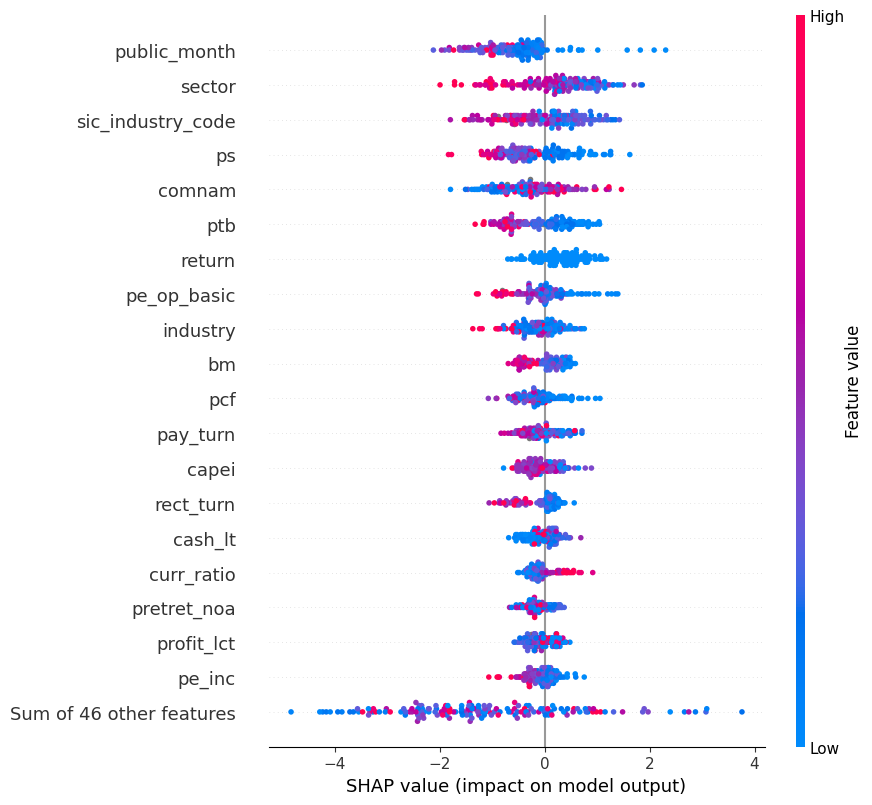

In [48]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

### Segment 2: 2006-10 to 2009-09


In [49]:
train = final_df.loc[(final_df['public_month'] >= segments[4][0])&(final_df['public_month'] <= segments[4][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[4][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.5406338886631451
F1 Score:: 0.08163265306122448


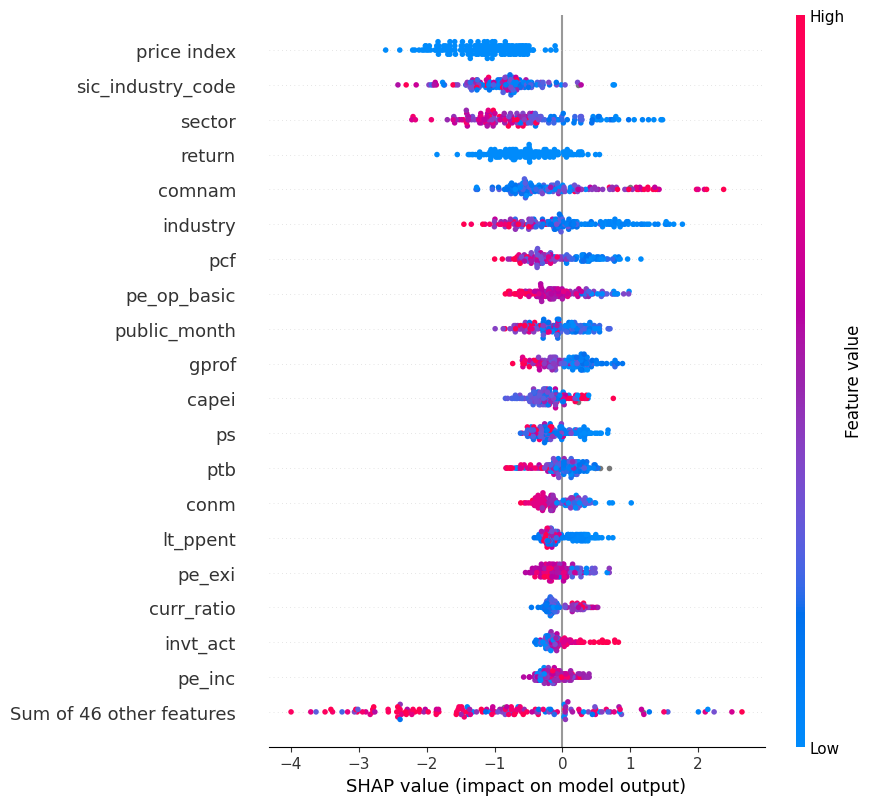

In [50]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

### Segment 3: 2009-10 to 2012-09


In [51]:
train = final_df.loc[(final_df['public_month'] >= segments[3][0])&(final_df['public_month'] <= segments[3][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[3][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.5450854700854701
F1 Score:: 0.39436619718309857


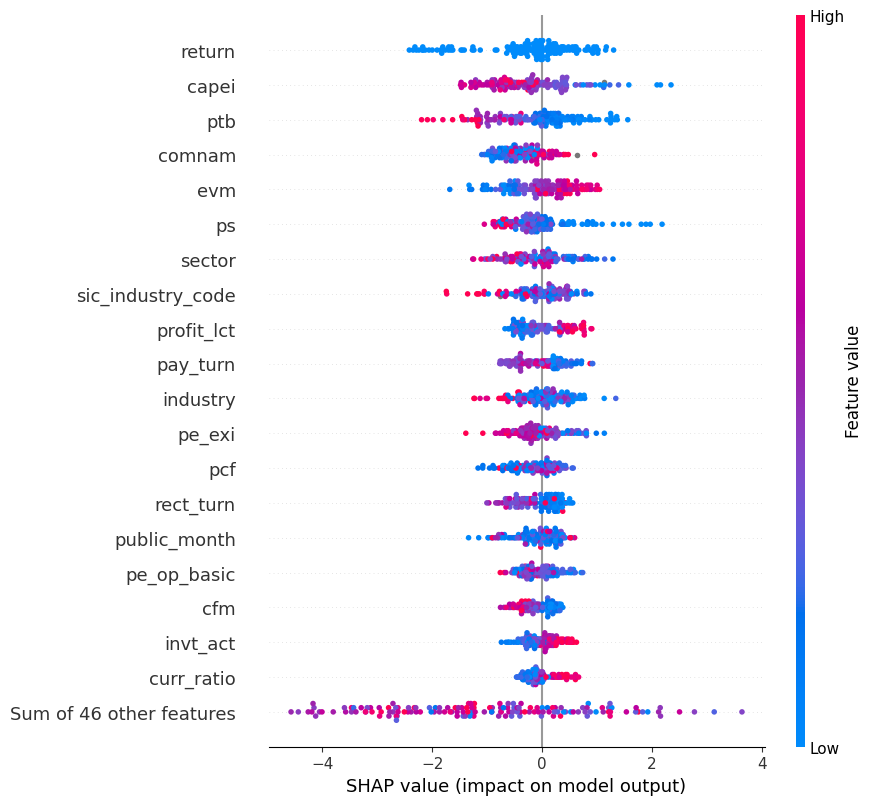

In [52]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

### Segment 4: 2012-10 to 2015-09


In [53]:
train = final_df.loc[(final_df['public_month'] >= segments[2][0])&(final_df['public_month'] <= segments[2][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[2][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.40579710144927533
F1 Score:: 0.11267605633802817


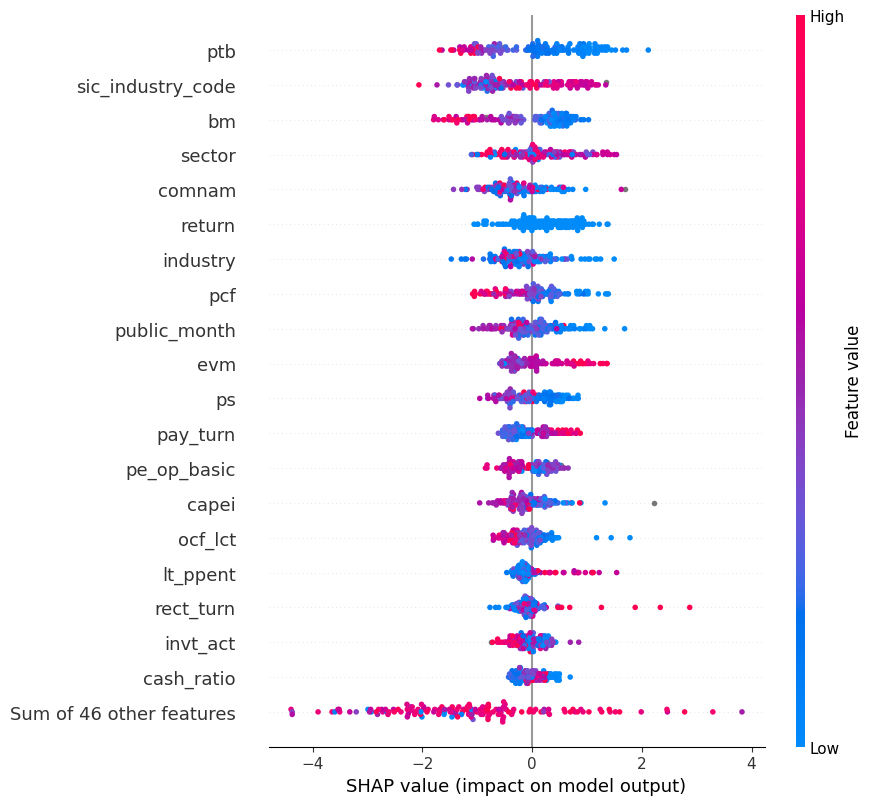

In [54]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

### Segment 5: 2015-10 to 2018-09


In [55]:
train = final_df.loc[(final_df['public_month'] >= segments[1][0])&(final_df['public_month'] <= segments[1][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[1][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.42103984450923226
F1 Score:: 0.3697478991596639


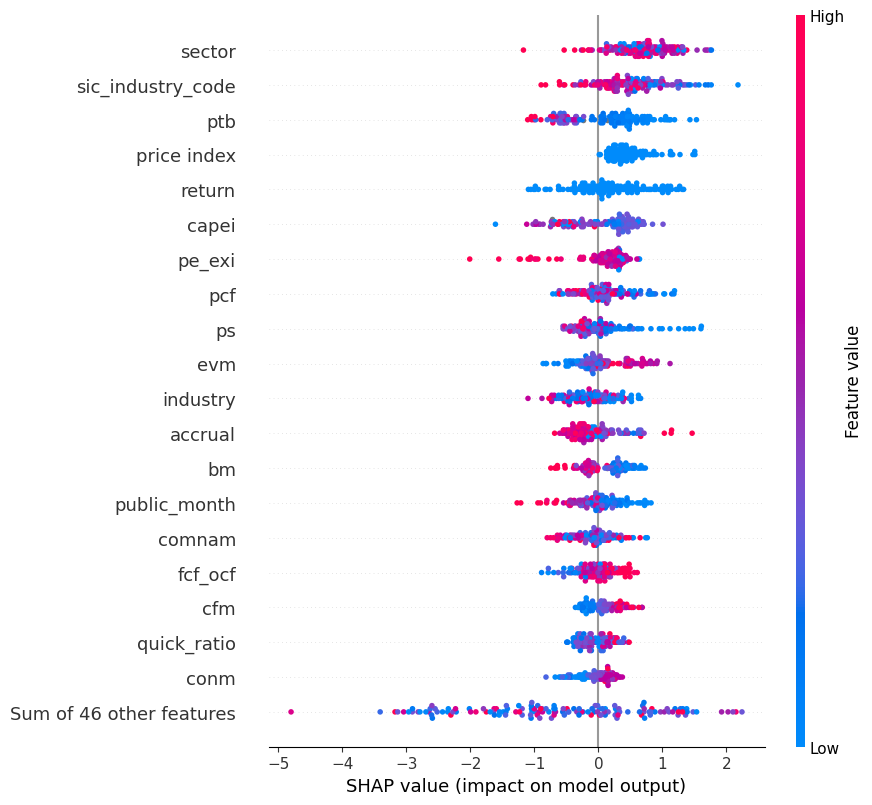

In [56]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

### Segment 6: 2018-10 to 2021-09


In [57]:
train = final_df.loc[(final_df['public_month'] >= segments[0][0])&(final_df['public_month'] <= segments[0][1])][numerical_cols]
test = final_df.loc[final_df['public_month'] == segments[0][1]+3]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])
y_test = test['label']


# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train, y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print(f"AUC-ROC Score: {auc_roc}")
print(f"F1 Score:: {f1}")

AUC-ROC Score: 0.7039794608472401
F1 Score:: 0.16


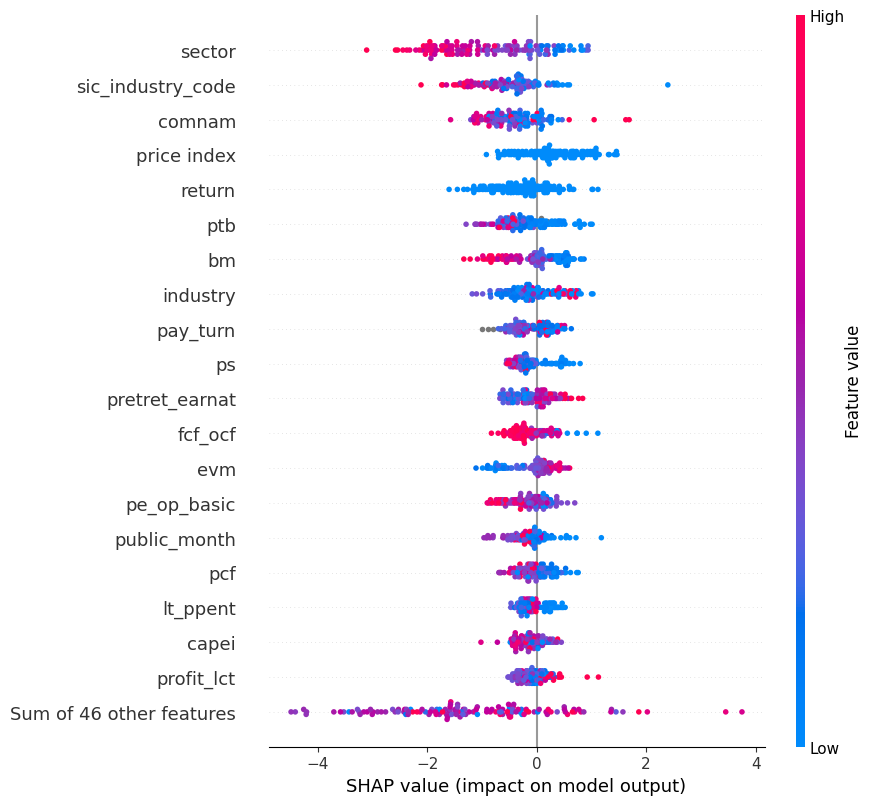

In [58]:
explainer = shap.TreeExplainer(pipe.steps[-1][1])
observations = pipe.steps[0][1].transform(X_test)
shap_values = explainer.shap_values(observations)

# Set feature names
feature_names = X_test.columns

# Create Explanation object with feature names
shap_explanation = shap.Explanation(
    values=shap_values,
    base_values=explainer.expected_value,
    data=observations,
    feature_names=feature_names
)

# Use the Explanation object in the beeswarm plot
shap.plots.beeswarm(shap_explanation, max_display=20)

## Final Model - Top Performing Tickers

In [59]:
df_holdout = df_unique.copy()
df_holdout['month'] = df_holdout['public_month'].apply(extract_month)
df_holdout['year'] = df_holdout['public_month'].apply(extract_year)

train = final_df.loc[(final_df['public_month'] >= pd.Period('2022-09','M')-35)&(final_df['public_month'] <= pd.Period('2022-09','M'))][numerical_cols]
test = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')][numerical_cols]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])



# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train,y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

# Create portfolio df
portfolio = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')].copy()
portfolio['y_pred'] = y_pred
portfolio = portfolio.loc[portfolio['y_pred']==1]
portfolio

# The model only predicts 21 tickers for class 1
tickers = list(portfolio['ticker'])
print(len(tickers))
tickers

21


['XOM',
 'PSX',
 'CVX',
 'MRO',
 'DD',
 'CTVA',
 'NEM',
 'HAL',
 'MUR',
 'HES',
 'HP',
 'NUE',
 'LPX',
 'TEX',
 'BKR',
 'X',
 'FCX',
 'NOV',
 'VLO',
 'FLR',
 'NRG']

In [60]:
# If we need to force 40 then go by proba
portfolio = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')].copy()
portfolio['pred_proba'] = y_proba
portfolio = portfolio.sort_values(by='pred_proba', ascending=False)[:40]

list(portfolio['ticker'])

['MUR',
 'BKR',
 'PSX',
 'FCX',
 'CVX',
 'NOV',
 'NUE',
 'HES',
 'VLO',
 'XOM',
 'HAL',
 'TEX',
 'LPX',
 'X',
 'HP',
 'CTVA',
 'NEM',
 'MRO',
 'NRG',
 'DD',
 'FLR',
 'CNX',
 'EOG',
 'CF',
 'PBI',
 'XYL',
 'PCG',
 'CLF',
 'ITT',
 'UAL',
 'COP',
 'AYI',
 'CE',
 'MTW',
 'MPC',
 'OXY',
 'DVN',
 'R',
 'ITW',
 'OI']

## Final Model - Worst Performing Tickers

In [61]:
# Re-encode labels. This is all redundant but didn't want to refactor the code above

def assign_label(x, lower_thres):
    return 1 if x <= lower_thres else 0

def calculate_thresholds(data):
    upper_thres = np.percentile(data, 70)
    lower_thres = np.percentile(data, 30)
    return upper_thres, lower_thres

df_unique = df_filtered_ticker.loc[:, unique_columns]

for month in public_months:
    # Filter data for the current month and remove rows with null 'forward 3m return'
    monthly_data = df_unique.loc[(df_unique['public_month'] == month) & (df_unique['forward 3m return'].notnull())]['forward 3m return'].values

    if len(monthly_data) > 0:
        _, lower_thres = calculate_thresholds(monthly_data)

        # Apply the assign_label function to the 'forward 3m return' array for the current month
        df_unique.loc[(df_unique['public_month'] == month) & (df_unique['forward 3m return'].notnull()), 'label'] = \
            np.vectorize(lambda x: assign_label(x, upper_thres))(monthly_data)


drop_cols = ['unnamed: 0', 'adate', 'qdate', 'public_date',
        'date','forward 1m return', 'forward 3m return', 'forward 6m return',
       'forward 12m return',
       'volatility adjusted forward 1m return',
       'volatility adjusted forward 3m return',
       'volatility adjusted forward 6m return', 'date_month', 'gvkey',
       'datadate', 'datadate_month']

df_intermediate = df_unique.drop(columns=drop_cols)

final_df = df_unique.loc[df_unique['label'].notnull()].copy()

final_df['month'] = final_df['public_month'].apply(extract_month)
final_df['year'] = final_df['public_month'].apply(extract_year)

assert len(final_df) == len(df_unique)-511


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [62]:
# Make sure there are around 40+ labelled 1
final_df[['public_month','label','permno']].groupby(['public_month','label']).count()

permno
public_month label        
2003-01      0.0        16
             1.0       142
2003-02      0.0        62
             1.0        96
2003-03      0.0        60
             1.0        98
2003-04      0.0        34
             1.0       124
2003-05      0.0        29
             1.0       129
2003-06      0.0        14
             1.0       144
2003-07      0.0        26
             1.0       132
2003-08      0.0        20
             1.0       138
2003-09      0.0        65
             1.0        93
2003-10      0.0        30
             1.0       128
2003-11      0.0        32
             1.0       126
2003-12      0.0        14
             1.0       143
2004-01      0.0        13
             1.0       144
2004-02      0.0        10
             1.0       147
2004-03      0.0        24
             1.0       133
2004-04      0.0        17
             1.0       140
2004-05      0.0         9
             1.0       149
2004-06      0.0         7
             1.0       151
2004-07      0.0         9
             1.0       148
2004-08      0.0        46
             1.0       111
2004-09      0.0        29
             1.0       128
2004-10      0.0        23
             1.0       134
2004-11      0.0        23
             1.0       134
2004-12      0.0        19
             1.0       139
2005-01      0.0         7
             1.0       151
2005-02      0.0         3
             1.0       154
2005-03      0.0         5
             1.0       153
2005-04      0.0        51
             1.0       107
2005-05      0.0        43
             1.0       115
2005-06      0.0        43
             1.0       115
2005-07      0.0         8
             1.0       150
2005-08      0.0        19
             1.0       137
2005-09      0.0        15
             1.0       141
2005-10      0.0        44
             1.0       112
2005-11      0.0        22
             1.0       134
2005-12      0.0        29
             1.0       127
2006-01      0.0        18
             1.0       138
2006-02      0.0        14
             1.0       141
2006-03      0.0         9
             1.0       147
2006-04      0.0         2
             1.0       154
2006-05      0.0         2
             1.0       155
2006-06      0.0         3
             1.0       153
2006-07      0.0        13
             1.0       143
2006-08      0.0        23
             1.0       133
2006-09      0.0        27
             1.0       129
2006-10      0.0        20
             1.0       136
2006-11      0.0        12
             1.0       144
2006-12      0.0        28
             1.0       128
2007-01      0.0        30
             1.0       126
2007-02      0.0        49
             1.0       107
2007-03      0.0        24
             1.0       132
2007-04      0.0        11
             1.0       145
2007-05      0.0         8
             1.0       148
2007-06      0.0         9
             1.0       147
2007-07      0.0        28
             1.0       128
2007-08      0.0        16
             1.0       140
2007-09      0.0        15
             1.0       141
2007-10      0.0         6
             1.0       151
2007-11      0.0        17
             1.0       140
2007-12      0.0         9
             1.0       148
2008-01      0.0        36
             1.0       121
2008-02      0.0        40
             1.0       117
2008-03      0.0        37
             1.0       120
2008-04      0.0        10
             1.0       146
2008-05      0.0         3
             1.0       153
2008-06      0.0         7
             1.0       149
2008-07      0.0         1
             1.0       155
2008-08      1.0       156
2008-09      0.0         2
             1.0       152
2008-10      0.0         4
             1.0       150
2008-11      0.0         9
             1.0       145
2008-12      0.0         7
             1.0       147
2009-01      0.0        40
             1.0       114
2009-02      0.0        99
             1.0        

In [63]:
df_holdout = df_unique.copy()
df_holdout['month'] = df_holdout['public_month'].apply(extract_month)
df_holdout['year'] = df_holdout['public_month'].apply(extract_year)

train = final_df.loc[(final_df['public_month'] >= pd.Period('2022-09','M')-35)&(final_df['public_month'] <= pd.Period('2022-09','M'))][numerical_cols]
test = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')][numerical_cols]

X_train = train.drop(columns=['label'])
y_train = train['label']
X_test = test.drop(columns=['label'])



# Prepare pipeline stages
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X_train.columns),
    ])

model = xgb.XGBClassifier(learning_rate=0.25, max_depth=15, n_estimators=1000)

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Fit model
fitted = pipe.fit(X_train,y_train)

#Predict labels and proba's
y_pred = fitted.predict(X_test)
y_proba = fitted.predict_proba(X_test)[:, 1]

portfolio = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')].copy()
portfolio['y_pred'] = y_pred
portfolio = portfolio.loc[portfolio['y_pred']==1]
portfolio

# The model only predicts 21 tickers for class 1
tickers = list(portfolio['ticker'])
print(len(tickers))
tickers

110


['HON',
 'ED',
 'FAST',
 'DTE',
 'WM',
 'GD',
 'ITT',
 'HII',
 'XYL',
 'PCG',
 'COP',
 'PAYC',
 'VMC',
 'EIX',
 'FTV',
 'DD',
 'SO',
 'DOW',
 'CAT',
 'CTVA',
 'FMC',
 'CARR',
 'OTIS',
 'LMT',
 'NEM',
 'IP',
 'EXC',
 'CNP',
 'EMR',
 'PPG',
 'PPL',
 'MMM',
 'FE',
 'CMS',
 'WEC',
 'CTAS',
 'PEG',
 'XEL',
 'ETR',
 'EVRG',
 'NEE',
 'HWM',
 'NOC',
 'OKE',
 'LHX',
 'DOV',
 'DUK',
 'PNW',
 'FLS',
 'MAS',
 'OXY',
 'ROL',
 'SHW',
 'WMB',
 'NI',
 'IFF',
 'CMI',
 'PH',
 'JBHT',
 'ATI',
 'SWK',
 'ES',
 'UNP',
 'MTW',
 'RHI',
 'EFX',
 'GWW',
 'LPX',
 'ITW',
 'LUV',
 'SNA',
 'FDX',
 'PAYX',
 'DLX',
 'CSX',
 'SWN',
 'NSC',
 'D',
 'AOS',
 'ECL',
 'PXD',
 'IEX',
 'EOG',
 'CTRA',
 'AES',
 'ODFL',
 'EMN',
 'MLM',
 'CPRT',
 'WAB',
 'SRCL',
 'ROK',
 'SEE',
 'SRE',
 'RSG',
 'DVN',
 'UPS',
 'PKG',
 'EXPD',
 'FLR',
 'AYI',
 'NRG',
 'MOS',
 'CE',
 'CF',
 'UAL',
 'TDG',
 'LDOS',
 'BR',
 'VRSK']

In [64]:
# We only want the top 40 worst predicted performed. Ranking based on predicted proba
portfolio = df_holdout.loc[df_holdout['public_month'] == pd.Period('2022-12','M')].copy()
portfolio['pred_proba'] = y_proba
portfolio = portfolio.sort_values(by='pred_proba', ascending=False)[:40]

list(portfolio['ticker'])

['SO',
 'EVRG',
 'CNP',
 'CMS',
 'XEL',
 'EXC',
 'ES',
 'IEX',
 'DUK',
 'D',
 'NI',
 'WEC',
 'FE',
 'ED',
 'CTAS',
 'PEG',
 'VRSK',
 'DTE',
 'PAYX',
 'SRE',
 'SNA',
 'RSG',
 'ETR',
 'EIX',
 'VMC',
 'EFX',
 'MMM',
 'PAYC',
 'BR',
 'NOC',
 'FAST',
 'SHW',
 'PPL',
 'GD',
 'GWW',
 'PNW',
 'WM',
 'AYI',
 'ECL',
 'FTV']

# **Q2(a). Equal Weighted Stock Portfolio**

In [65]:
equal_wt_portfolio = df_unique.copy()
equal_wt_portfolio.head()


,unnamed: 0,gvkey,permno,adate,qdate,public_date,capei,bm,evm,pe_op_basic,pe_op_dil,pe_exi,pe_inc,ps,pcf,npm,opmbd,opmad,gpm,ptpm,cfm,roa,roe,roce,aftret_eq,pretret_noa,pretret_earnat,gprof,equity_invcap,debt_invcap,totdebt_invcap,capital_ratio,cash_lt,invt_act,rect_act,debt_at,debt_ebitda,curr_debt,lt_debt,profit_lct,ocf_lct,cash_debt,fcf_ocf,lt_ppent,dltt_be,debt_assets,debt_capital,de_ratio,cash_ratio,quick_ratio,curr_ratio,at_turn,rect_turn,pay_turn,sale_invcap,sale_equity,rd_sale,adv_sale,accrual,ptb,ticker,cusip,conm,industry,sector,public_month,date,sic_industry_code,comnam,volume,return,price index,forward 1m return,forward 3m return,forward 6m return,forward 12m return,past return 1m,past return 12m,volatility,volatility adjusted forward 1m return,volatility adjusted forward 3m return,volatility adjusted forward 6m return,date_month,datadate,mcap,datadate_month,month,year,label
0,1,12136,10078,2002-06-30,2002-09-30,2003-01-31,11.925,1.154,48.234,-206.000,-206.000,-77.250,-77.250,0.797,13.542,-0.042,0.041,-0.043,0.487,-0.076,0.042,0.030,-0.052,-0.047,-0.052,-0.102,-0.053,0.366,0.899,0.134,0.147,0.131,0.359,0.077,0.336,0.096,3.120,0.703,0.213,0.106,0.153,0.131,0.412,2.727,0.149,0.412,0.182,0.702,0.510,1.431,1.550,0.751,4.967,6.596,1.150,1.278,0.145,0.01,-0.075,1.061,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-01,2003-01-31,3570.0,SUN MICROSYSTEMS INC,11399374.0,-0.006431,1.000000,0.113269,0.071197,0.216828,0.711003,-0.006431,NaN,NaN,NaN,NaN,NaN,2003-01,NaT,NaN,NaT,1,2003,1.0
1,2,12136,10078,2002-06-30,2002-12-31,2003-02-28,16.320,0.732,22.761,-57.333,-57.333,-18.595,-18.595,0.902,13.947,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.511,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-02,2003-02-28,3570.0,SUN MICROSYSTEMS INC,8671118.0,0.113269,1.113269,-0.052326,0.264533,0.133720,0.543604,0.113269,NaN,NaN,NaN,NaN,NaN,2003-02,NaT,NaN,NaT,2,2003,0.0
2,3,12136,10078,2002-06-30,2002-12-31,2003-03-31,15.635,0.732,22.761,-54.333,-54.333,-17.622,-17.622,0.864,13.361,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.448,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-03,2003-03-31,3570.0,SUN MICROSYSTEMS INC,10570497.0,-0.052326,1.055016,0.015337,0.426380,0.015337,0.279141,-0.052326,NaN,NaN,NaN,NaN,NaN,2003-03,NaT,NaN,NaT,3,2003,0.0
3,4,12136,10078,2002-06-30,2002-12-31,2003-04-30,15.874,0.732,22.761,-55.167,-55.167,-17.892,-17.892,0.877,13.566,-0.194,0.062,-0.024,0.506,-0.220,-0.108,0.046,-0.245,-0.026,-0.245,-0.057,-0.030,0.396,0.861,0.139,0.149,0.139,0.402,0.073,0.342,0.101,2.063,0.710,0.224,0.164,0.170,0.131,0.486,2.695,0.162,0.420,0.214,0.723,0.566,1.459,1.574,0.783,4.881,6.559,1.162,1.350,0.150,0.01,-0.199,1.470,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-04,2003-04-30,3570.0,SUN MICROSYSTEMS INC,10668815.0,0.015337,1.071197,0.314199,0.135952,0.193354,0.178249,0.015337,NaN,NaN,NaN,NaN,NaN,2003-04,NaT,NaN,NaT,4,2003,1.0
4,5,12136,10078,2002-06-30,2003-03-31,2003-05-31,26.985,0.699,16.357,-75.652,-75.652,-23.836,-23.836,1.183,15.983,-0.196,0.066,-0.014,0.505,-0.218,-0.117,0.050,-0.258,-0.015,-0.258,-0.032,-0.017,0.407,0.850,0.150,0.155,0.150,0.427,0.070,0.351,0.105,1.982,0.715,0.237,0.173,0.195,0.131,0.618,2.664,0.177,0.427,0.223,0.746,0.598,1.454,1.564,0.806,4.808,6.500,1.196,1.407,0.153,0.01,-0.212,1.909,SUNW,86681010,SUNWORKS INC,201040.0,20.0,2003-05,2003-05-30,3570.0,SUN MICROSYSTEMS INC,13469662.0,0.314199,1.407766,0.068966,-0.103448,-0.020689,-0.041378,0.314199,NaN,NaN,NaN,NaN,NaN,2003-05,NaT,NaN,NaT,5,2003,1.0


In [66]:
# Define the file path and name
file_path = 'final.xlsx'

# Write the DataFrame to an Excel file
equal_wt_portfolio.to_excel(file_path)

In [67]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm
import numpy as np

# Define tickers and time frame
TICKERS = ['MUR', 'BKR', 'PSX', 'FCX', 'CVX', 'NOV', 'NUE', 'HES', 'VLO', 'XOM',
           'HAL', 'TEX', 'LPX', 'X', 'HP', 'CTVA', 'NEM', 'MRO', 'NRG', 'DD',
           'FLR', 'CNX', 'EOG', 'CF', 'PBI', 'XYL', 'PCG', 'CLF', 'ITT', 'UAL',
           'COP', 'AYI', 'CE', 'MTW', 'MPC', 'OXY', 'DVN', 'R', 'ITW', 'OI',
           '^GSPC', '^IRX']


TICKERS_21 = [ 'XOM', 'PSX','CVX', 'MRO', 'DD', 'CTVA', 'NEM','HAL','MUR','HES','HP','NUE','LPX','TEX','BKR','X','FCX','NOV', 'VLO','FLR','NRG', '^GSPC', '^IRX' ]

START_DATE = '2021-12-31'
END_DATE = '2022-12-31'

# Download historical data
df = yf.download(TICKERS, start=START_DATE, end=END_DATE, progress=False)

# Calculate weekly returns
df_weekly_returns = df['Adj Close'].resample('W').ffill().pct_change()

# Calculate the weekly risk-free rate
df_weekly_returns['^IRX_weekly'] = (df_weekly_returns['^IRX'] * 0.01) / 52

# Calculate 12-month volatility (using weekly returns for a rough estimate)
annual_volatility = df_weekly_returns.std() * np.sqrt(52)  # Approximation using weekly data

# Calculate beta for each stock
betas = {}
for ticker in TICKERS:
    if ticker in ['^GSPC', '^IRX']: continue  # Skip indices
    y = df_weekly_returns[ticker] - df_weekly_returns['^IRX_weekly']
    X = df_weekly_returns['^GSPC'] - df_weekly_returns['^IRX_weekly']
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    betas[ticker] = model.params[0]

# Fetch market cap (latest)
market_caps = {ticker: yf.Ticker(ticker).info.get('marketCap') for ticker in TICKERS if ticker not in ['^GSPC', '^IRX']}
import pandas as pd

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Ticker': TICKERS[:-2],  # Exclude '^GSPC', '^IRX' from the ticker list for the results
    'Market Cap': [market_caps.get(ticker) for ticker in TICKERS if ticker not in ['^GSPC', '^IRX']],
    'Market Beta': [betas.get(ticker) for ticker in TICKERS if ticker not in ['^GSPC', '^IRX']],
    '12-Month Volatility': [annual_volatility.get(ticker) for ticker in TICKERS if ticker not in ['^GSPC', '^IRX']]
})

# Replacing None with np.nan to compute statistics correctly
results_df = results_df.fillna(value=np.nan)

# Print the DataFrame
print(results_df.to_string(index=False))
results_df.to_excel('top40.xlsx', index= False)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


Ticker   Market Cap  Market Beta  12-Month Volatility
   MUR   6011799040     1.379858             0.631300
   BKR  29324267520     0.596929             0.492416
   PSX  62264000512     0.664654             0.411603
   FCX  55846350848     1.192466             0.545911
   CVX 287349243904     0.627086             0.384693
   NOV   6800508928     0.936064             0.605820
   NUE  45855121408     1.450472             0.541683
   HES  45929484288     0.960712             0.508983
   VLO  47637884928     0.560364             0.446409
   XOM 413778182144     0.578528             0.388768
   HAL  31545214976     0.943563             0.571131
   TEX   3727209984     1.348335             0.443200
   LPX   4986444288     1.258049             0.463557
     X  10282630144     1.893689             0.707413
    HP   3939050496     1.364697             0.625670
  CTVA  38461214720     0.766056             0.286116
   NEM  38534541312     0.379269             0.369722
   MRO  13708883968     1.00

In [68]:
TICKERS_21 = ['XOM', 'PSX','CVX', 'MRO', 'DD', 'CTVA', 'NEM','HAL','MUR','HES','HP','NUE','LPX','TEX','BKR','X','FCX','NOV', 'VLO','FLR','NRG', '^GSPC', '^IRX' ]

START_DATE = '2021-12-31'
END_DATE = '2022-12-31'

# Download historical data
df = yf.download(TICKERS_21, start=START_DATE, end=END_DATE, progress=False)

# Calculate weekly returns
df_weekly_returns = df['Adj Close'].resample('W').ffill().pct_change()

# Calculate the weekly risk-free rate
df_weekly_returns['^IRX_weekly'] = (df_weekly_returns['^IRX'] * 0.01) / 52

# Calculate 12-month volatility (using weekly returns for a rough estimate)
annual_volatility = df_weekly_returns.std() * np.sqrt(52)  # Approximation using weekly data

# Calculate beta for each stock
betas = {}
for ticker in TICKERS_21:
    if ticker in ['^GSPC', '^IRX']: continue  # Skip indices
    y = df_weekly_returns[ticker] - df_weekly_returns['^IRX_weekly']
    X = df_weekly_returns['^GSPC'] - df_weekly_returns['^IRX_weekly']
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    betas[ticker] = model.params[0]

# Fetch market cap (latest)
market_caps = {ticker: yf.Ticker(ticker).info.get('marketCap') for ticker in TICKERS_21 if ticker not in ['^GSPC', '^IRX']}
import pandas as pd

# Create a DataFrame to hold the results
results_df = pd.DataFrame({
    'Ticker': TICKERS_21[:-2],  # Exclude '^GSPC', '^IRX' from the ticker list for the results
    'Market Cap': [market_caps.get(ticker) for ticker in TICKERS_21 if ticker not in ['^GSPC', '^IRX']],
    'Market Beta': [betas.get(ticker) for ticker in TICKERS_21 if ticker not in ['^GSPC', '^IRX']],
    '12-Month Volatility': [annual_volatility.get(ticker) for ticker in TICKERS_21 if ticker not in ['^GSPC', '^IRX']]
})

# Replacing None with np.nan to compute statistics correctly
results_df = results_df.fillna(value=np.nan)

# Print the DataFrame
print(results_df.to_string(index=False))
results_df.to_excel('top21.xlsx', index= False)

Ticker   Market Cap  Market Beta  12-Month Volatility
   XOM 413917184000     0.578528             0.388768
   PSX  62251102208     0.664655             0.411603
   CVX 287312216064     0.627087             0.384693
   MRO  13709410304     1.006379             0.575131
    DD  28667074560     1.198696             0.355476
  CTVA  38433144832     0.766056             0.286116
   NEM  38521978880     0.379270             0.369723
   HAL  31527411712     0.943561             0.571131
   MUR   6011799040     1.379859             0.631300
   HES  45906448384     0.960712             0.508983
    HP   3934287104     1.364697             0.625670
   NUE  45826850816     1.450472             0.541683
   LPX   4988611584     1.258049             0.463557
   TEX   3723860224     1.348335             0.443200
   BKR  29349466112     0.596929             0.492417
     X  10281512960     1.893690             0.707413
   FCX  55810498560     1.192467             0.545911
   NOV   6792628736     0.93

In [69]:
import pandas as pd
import yfinance as yf

# Load the Excel file into a pandas DataFrame
marketcap_df = pd.read_excel('MarketCap_Data.xlsx', sheet_name='Sheet1')

# Convert 'datadate' to datetime format
marketcap_df['datadate'] = pd.to_datetime(marketcap_df['datadate'])

# Check if the Mcap for 31-12-2022 is present
check_date = pd.Timestamp('2022-12-31')
tickers_to_download = []

# Initialize a dictionary to store the Mcap and source information
mcap_dict = {}

# Check each row to see if there's an entry for 31-12-2022
for ticker in marketcap_df['ticker'].unique():
    ticker_data = marketcap_df.loc[marketcap_df['ticker'] == ticker]
    if check_date in ticker_data['datadate'].values:
        # If Mcap for 31-12-2022 is present, get the Mcap from the DataFrame
        mcap = ticker_data.loc[ticker_data['datadate'] == check_date, 'Mcap'].values[0]
        mcap_dict[ticker] = (mcap, 'DataFrame')
    else:
        # If Mcap for 31-12-2022 is not present, add the ticker to the list to download from Yahoo Finance
        tickers_to_download.append(ticker)

# Download Mcap from Yahoo Finance if not present
for ticker in tickers_to_download:
    stock = yf.Ticker(ticker)
    # Get data for December 2022
    data = stock.history(start='2022-12-01', end='2023-01-01')
    # Get the last available market cap in December 2022
    # Since actual shares outstanding data is not available, we'll use the closing price
    # and the volume as a rough estimate for the market cap.
    if not data.empty:
        mcap = data['Close'][-1] * data['Volume'][-1]  # This is an approximation
        mcap_dict[ticker] = (mcap, 'Yahoo Finance')

mcap_dict


ERROR:yfinance:AET: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:WYE: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:BHI: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:OMX: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:STZ.B: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:PVN: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:CMCSK: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:CTB: No timezone found, symbol may be delisted
ERROR:yfinance:TRY: No price data found, symbol may be delisted (1d 2022-12-01 -> 2023-01-01)
ERROR:yfinance:DALRQ: No timezone found, symbol may be delisted
ERROR:yfinance:DG.1: No timezone found, symbol may be delisted
ERROR:yfinance:FDO: No price data found, symbol may be 

{'PNW': (8605.674920000001, 'DataFrame'),
 'HON': (143066.68000000002, 'DataFrame'),
 'SWKS': (14498.783, 'DataFrame'),
 'HES': (43422.02214, 'DataFrame'),
 'VZ': (165474.56279999999, 'DataFrame'),
 'RHI': (7951.343339999999, 'DataFrame'),
 'BMY': (150951.1, 'DataFrame'),
 'BC': (5143.989199999999, 'DataFrame'),
 'UIS': (346.458, 'DataFrame'),
 'CI': (98963.30583999999, 'DataFrame'),
 'CSX': (64016.049660000004, 'DataFrame'),
 'CPB': (16968.25, 'DataFrame'),
 'STZ': (42755.78925, 'DataFrame'),
 'CAH': (19909.33, 'DataFrame'),
 'CAT': (123695.84776, 'DataFrame'),
 'LUMN': (5228.81136, 'DataFrame'),
 'JPM': (393483.99779999995, 'DataFrame'),
 'CVX': (343762.29933, 'DataFrame'),
 'CHD': (19660.45656, 'DataFrame'),
 'CTAS': (45885.04362, 'DataFrame'),
 'CLF': (8269.92351, 'DataFrame'),
 'CLX': (17327.66774, 'DataFrame'),
 'KO': (275304.08, 'DataFrame'),
 'CL': (65412.48227, 'DataFrame'),
 'CMCSA': (147577.56142999997, 'DataFrame'),
 'CMA': (8755.14395, 'DataFrame'),
 'C': (87609.8767799999

In [70]:
import pandas as pd
import yfinance as yf

# Define the list of tickers we are interested in
tickers_list = [
    'MUR', 'BKR', 'PSX', 'FCX', 'CVX', 'NOV', 'NUE', 'HES', 'VLO', 'XOM',
    'HAL', 'TEX', 'LPX', 'X', 'HP', 'CTVA', 'NEM', 'MRO', 'NRG', 'DD',
    'FLR', 'CNX', 'EOG', 'CF', 'PBI', 'XYL', 'PCG', 'CLF', 'ITT', 'UAL',
    'COP', 'AYI', 'CE', 'MTW', 'MPC', 'OXY', 'DVN', 'R', 'ITW', 'OI'
]

# Load the Excel file into a pandas DataFrame
marketcap_df = pd.read_excel('MarketCap_Data.xlsx', sheet_name='Sheet1')

# Convert 'datadate' to datetime format
marketcap_df['datadate'] = pd.to_datetime(marketcap_df['datadate'])

# Check if the Mcap for 31-12-2022 is present
check_date = pd.Timestamp('2022-12-31')

# Initialize a dictionary to store the Mcap and source information
mcap_dict = {}

# Check for each ticker in the list
for ticker in tickers_list:
    if ticker in marketcap_df['ticker'].values:
        ticker_data = marketcap_df.loc[marketcap_df['ticker'] == ticker]
        if check_date in ticker_data['datadate'].values:
            # If Mcap for 31-12-2022 is present, get the Mcap from the DataFrame
            mcap = ticker_data.loc[ticker_data['datadate'] == check_date, 'Mcap'].values[0]
            mcap_dict[ticker] = (mcap, 'DataFrame')
        else:
            # If Mcap for 31-12-2022 is not present, download it from Yahoo Finance
            stock = yf.Ticker(ticker)
            data = stock.history(start='2022-12-01', end='2023-01-01')
            if not data.empty:
                # Using closing price of the last day in December as a rough proxy for market cap
                mcap = data['Close'][-1] * data['Volume'][-1]  # This is an approximation
                mcap_dict[ticker] = (mcap, 'Yahoo Finance')
    else:
        # If the ticker is not in the DataFrame, download it from Yahoo Finance
        stock = yf.Ticker(ticker)
        data = stock.history(start='2022-12-01', end='2023-01-01')
        if not data.empty:
            # Using closing price of the last day in December as a rough proxy for market cap
            mcap = data['Close'][-1] * data['Volume'][-1]  # This is an approximation
            mcap_dict[ticker] = (mcap, 'Yahoo Finance')

# The output will be a dictionary with the market cap and source for each ticker
mcap_dict


{'MUR': (55712112.59613037, 'Yahoo Finance'),
 'BKR': (108939692.39349365, 'Yahoo Finance'),
 'PSX': (208998595.00579834, 'Yahoo Finance'),
 'FCX': (254452841.10908508, 'Yahoo Finance'),
 'CVX': (343762.29933, 'DataFrame'),
 'NOV': (26323822.208595276, 'Yahoo Finance'),
 'NUE': (148129384.11865234, 'Yahoo Finance'),
 'HES': (43422.02214, 'DataFrame'),
 'VLO': (249051406.59332275, 'Yahoo Finance'),
 'XOM': (1246938520.175171, 'Yahoo Finance'),
 'HAL': (202033148.8380432, 'Yahoo Finance'),
 'TEX': (11918570.656585693, 'Yahoo Finance'),
 'LPX': (32173074.43962097, 'Yahoo Finance'),
 'X': (89469302.31685638, 'Yahoo Finance'),
 'HP': (31430424.30496216, 'Yahoo Finance'),
 'CTVA': (107943788.13858032, 'Yahoo Finance'),
 'NEM': (177914471.6972351, 'Yahoo Finance'),
 'MRO': (191657351.22375488, 'Yahoo Finance'),
 'NRG': (70561936.88964844, 'Yahoo Finance'),
 'DD': (96857911.6104126, 'Yahoo Finance'),
 'FLR': (23395499.897003174, 'Yahoo Finance'),
 'CNX': (25595116.231918335, 'Yahoo Finance'),


# **Q3.Portfolio Optimization & 2023 Returns**

In [71]:
!pip install riskfolio-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.4/293.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 16.1 MB/s eta 0:00:00


In [72]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings

warnings.filterwarnings("ignore")

yf.pdr_override()
pd.options.display.float_format = '{:.4%}'.format

# Date range
start = '2003-01-01'
end = '2022-12-31'

# Tickers of assets
CLASS_1_STOCKS_LOOKBACK_SCALED = ['XOM','PSX','CVX','MRO','DD','CTVA','NEM',
                                  'HAL','MUR','HES','HP','NUE','LPX','TEX',
                                  'BKR','X','FCX','NOV','VLO','FLR','NRG']

TOP_40_STOCKS_LOOKBACK_SCALED = ['MUR','BKR','PSX','FCX','CVX','NOV','NUE',
                                 'HES','VLO','XOM','HAL','TEX','LPX','X','HP',
                                 'CTVA','NEM','MRO','NRG','DD','FLR','CNX',
                                 'EOG','CF','PBI','XYL','PCG','CLF','ITT',
                                 'UAL','COP','AYI','CE','MTW','MPC','OXY',
                                 'DVN','R','ITW','OI']


CLASS_1_STOCKS_MONTHLY_SCALED = ['XOM','GD','MPC','PSX','FANG','PCG','COP',
                                 'CVX','MRO','CAT','CTVA','PPG','CTAS','EQT',
                                 'PBI','NOC','MUR','HES','NUE','PH','GWW','ITW',
                                 'LUV','CSX','AOS','CTRA','OI','FCX','ROK','VLO',
                                 'NRG','UAL']


TOP_40_STOCKS_MONTHLY_SCALED = ['NUE','MUR','MPC','MRO','OI','CVX','PSX','PBI',
                                'CTVA','VLO','XOM','CTRA','UAL','FCX','CTAS',
                                'HES','PCG','GWW','NRG','COP','PPG','NOC',
                                'AOS','GD','ITW','FANG','EQT','LUV','CSX',
                                'ROK','CAT','PH','HAL','DD','CF','DOW','AYI',
                                'DOV','LPX','NEE']

ETFS = ['PDBC', 'GLDM', 'IEBC.L', 'IBGS.L']

def assets_list(stocks):
  return stocks + ETFS

my_assets = assets_list(CLASS_1_STOCKS_LOOKBACK_SCALED)

# Downloading data for stock portfolio
data = yf.download(CLASS_1_STOCKS_LOOKBACK_SCALED, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = CLASS_1_STOCKS_LOOKBACK_SCALED
#Calculating returns
stock_returns = data[CLASS_1_STOCKS_LOOKBACK_SCALED].pct_change().dropna()
display(stock_returns.head())



[*********************100%%**********************]  21 of 21 completed


,XOM,PSX,CVX,MRO,DD,CTVA,NEM,HAL,MUR,HES,HP,NUE,LPX,TEX,BKR,X,FCX,NOV,VLO,FLR,NRG
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-28,-0.1801%,-0.8104%,-0.3370%,-0.9974%,-0.4960%,-1.7562%,0.0871%,-0.4876%,-2.4371%,-0.9590%,-0.6930%,-0.4295%,-0.7832%,-2.1885%,-1.4354%,-0.2932%,-0.5064%,-1.3153%,-1.4826%,-2.7146%,-2.0108%
2019-05-29,-2.1200%,-0.9213%,-1.3017%,1.0400%,-0.3988%,0.8062%,0.0870%,-1.0815%,3.5743%,1.1003%,-1.6748%,-0.0392%,-0.2211%,-1.0959%,-2.1131%,-0.4901%,0.2788%,0.2161%,-0.3063%,-3.0920%,-0.6197%
2019-05-30,-2.4424%,1.0526%,-1.1904%,0.2573%,-1.7017%,0.0000%,-3.6506%,-1.2812%,-1.6078%,-0.9142%,-3.3357%,-2.3539%,1.5506%,-2.7239%,-1.5753%,-2.9157%,-0.8339%,-0.3954%,-2.6583%,-4.9805%,-0.2633%
2019-05-31,1.1337%,-6.3542%,-1.3261%,-2.0853%,-1.1201%,-2.9072%,-3.9693%,-3.3397%,-2.5309%,0.2636%,-3.4508%,-0.1607%,3.1162%,-1.0441%,0.8892%,-2.5974%,-1.5354%,-3.3923%,-3.3896%,-3.1941%,-1.6674%
2019-06-03,2.0084%,-8.0089%,1.8797%,17.8154%,2.1627%,1.7316%,1.4561%,-2.0229%,1.7992%,1.2708%,1.3688%,-0.8048%,1.6319%,1.7746%,0.7051%,3.7083%,1.7326%,0.1121%,2.2727%,5.9222%,1.5685%


In [73]:
# Calculate the Historical Return series of an equal-weighted portfolio of stocks

stock_port_weights = [0.1]*len(CLASS_1_STOCKS_LOOKBACK_SCALED)
weighted_returns = (stock_port_weights * stock_returns)
stock_port_ret = weighted_returns.sum(axis=1) # Historical Returns of the Stock Portion
stock_port_ret = pd.DataFrame(stock_port_ret)
stock_port_ret.columns = ['MY_STOCK_Portf']
stock_port_ret

,MY_STOCK_Portf
Date,
2019-05-28,-2.2226%
2019-05-29,-0.8373%
2019-05-30,-3.1964%
2019-05-31,-3.8662%
2019-06-03,4.0084%
2019-06-04,5.1066%
2019-06-05,-0.9845%
2019-06-06,1.2738%
2019-06-07,1.1708%


In [74]:
# Collect the returns data for the ETFs
# Downloading data for stock portfolio
data = yf.download(ETFS, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = ETFS
#Calculating returns
etf_returns = data[ETFS].pct_change().dropna()
etf_returns = pd.DataFrame(etf_returns)
display(etf_returns.head())

[*********************100%%**********************]  4 of 4 completed


,PDBC,GLDM,IEBC.L,IBGS.L
Date,,,,
2018-06-27,-0.5402%,0.1344%,0.0789%,0.5504%
2018-06-28,-0.2716%,0.3868%,0.1928%,0.0000%
2018-06-29,0.3123%,-0.0079%,0.0087%,1.0399%
2018-07-02,-0.9182%,0.0157%,-0.0700%,-1.8960%
2018-07-03,1.0475%,0.0197%,0.0875%,-0.5522%


In [75]:
# Now, combine the historical returns of the ETFs with the Stock Portfolio Returns
all_returns = pd.merge(etf_returns, stock_port_ret, on='Date')
display(all_returns.head())

,PDBC,GLDM,IEBC.L,IBGS.L,MY_STOCK_Portf
Date,,,,,
2019-05-28,-0.3897%,-0.2277%,-0.0947%,0.7966%,-2.2226%
2019-05-29,0.0000%,0.0000%,-0.0732%,-0.1824%,-0.8373%
2019-05-30,0.7042%,0.1731%,0.2975%,-1.0962%,-3.1964%
2019-05-31,1.3209%,-0.0196%,-0.0215%,-2.7093%,-3.8662%
2019-06-03,1.4571%,0.4911%,0.4472%,-0.4431%,4.0084%


In [76]:
import riskfolio as rp


# Building the portfolio object
port = rp.Portfolio(returns=all_returns)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w)

,weights
PDBC,66.5584%
GLDM,0.0007%
IEBC.L,0.0000%
IBGS.L,21.3134%
MY_STOCK_Portf,12.1276%


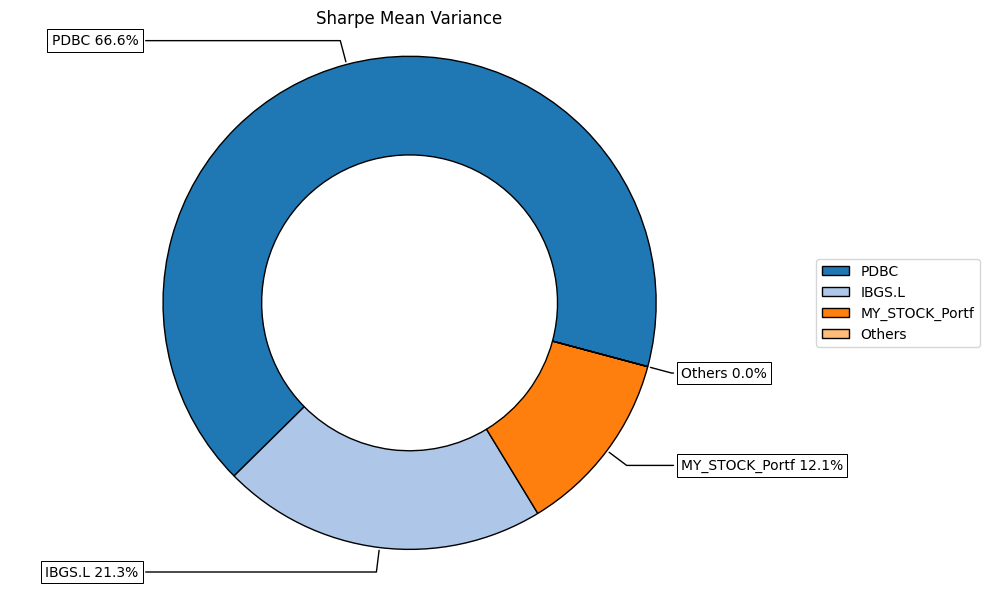

In [77]:
# Plotting the composition of the portfolio

ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

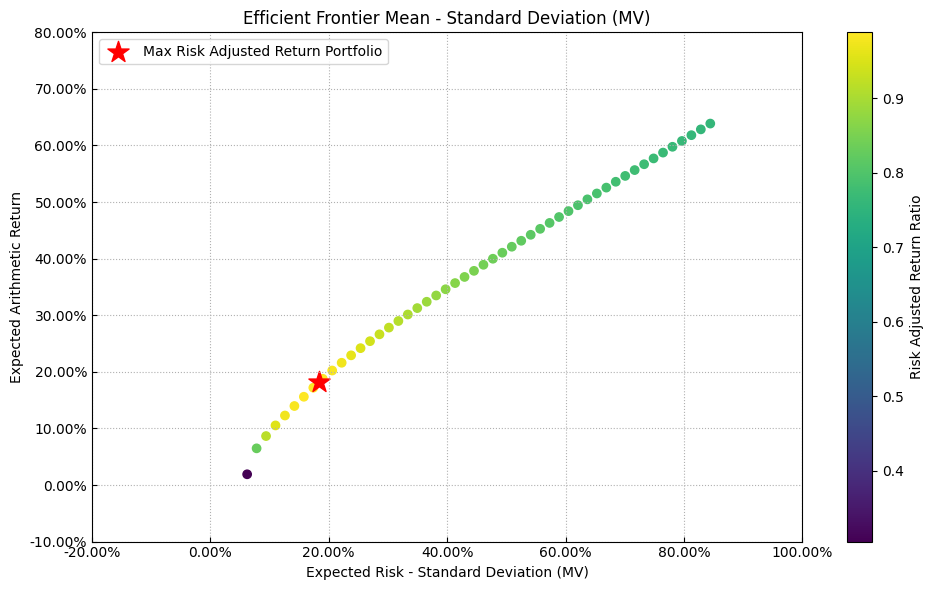

In [78]:
points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)

# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)

In [79]:
asset_classes = {'Assets': ['PDBC', 'GLDM', 'IEBC.L', 'IBGS.L', 'MY_STOCK_Portf'],
                 'Group': ['ETF', 'ETF','ETF','ETF', 'MY_STOCKS']}

asset_classes = pd.DataFrame(asset_classes)
#asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False],
               'Type': ['Classes', 'Classes', 'Classes', 'Classes', 'Classes'],
               'Set': ['Group', 'Group', 'Group', 'Group', 'Group'],
               'Position': ['ETF', 'ETF', 'ETF','ETF', 'MY_STOCKS'],
               'Sign': ['>=', '>=', '>=', '>=', '>='],
               'Weight': [0.01, 0.01, 0.01,0.01, 0.5],
               'Type Relative': ['', '', '', '', ''],
               'Relative Set': ['', '', '', '', ''],
               'Relative': ['', '', '', '', ''],
               'Factor': ['', '', '', '', '']}

constraints = pd.DataFrame(constraints)

In [80]:
display(asset_classes)


,Assets,Group
0,PDBC,ETF
1,GLDM,ETF
2,IEBC.L,ETF
3,IBGS.L,ETF
4,MY_STOCK_Portf,MY_STOCKS


In [81]:
A, B = rp.assets_constraints(constraints, asset_classes)

In [82]:
port.ainequality = A
port.binequality = B

model = 'Classic'
rm = 'MV'
obj = 'Sharpe'
rf = 0

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.transpose())

,PDBC,GLDM,IEBC.L,IBGS.L,MY_STOCK_Portf
weights,50.0000%,0.0000%,0.0000%,0.0000%,50.0000%


In [83]:
my_weights = w.T
my_weights.columns = ['PDBC', 'GLDM', 'IEBC.L', 'IBGS.L', 'MY_STOCKS']
display(my_weights)

,PDBC,GLDM,IEBC.L,IBGS.L,MY_STOCKS
weights,50.0000%,0.0000%,0.0000%,0.0000%,50.0000%


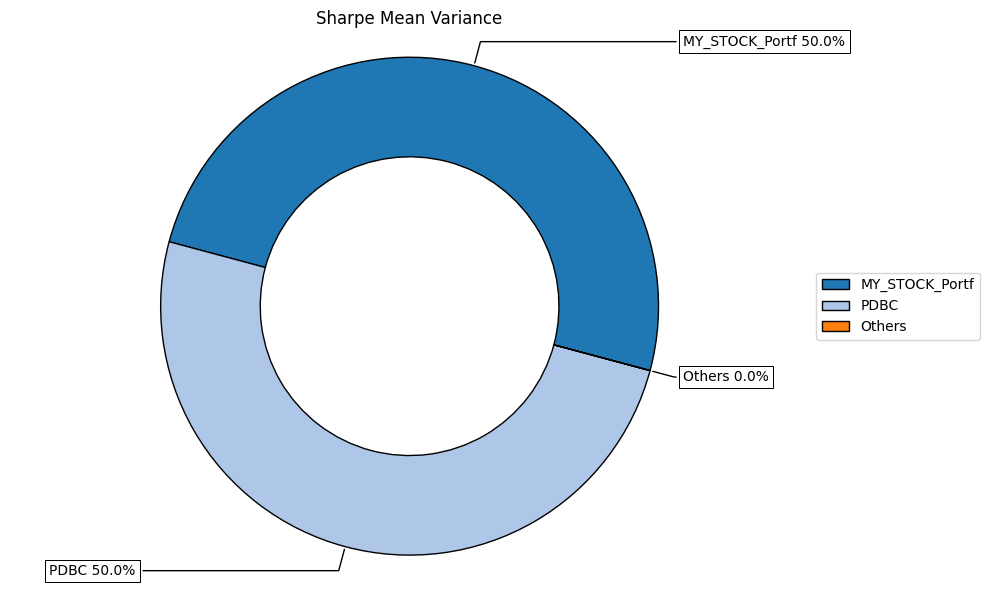

In [84]:
ax = rp.plot_pie(w=w, title='Sharpe Mean Variance', others=0.01, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)


What has been the return of this portfolio in 2022? Let's collect the price data in 2022 and calculate

In [85]:

# Date range
start = '2023-01-01'
end = '2023-12-31'

# Tickers of assets
my_stocks = ['XOM','PSX','CVX','MRO','DD','CTVA','NEM','HAL','MUR','HES','HP',
             'NUE','LPX','TEX','BKR','X','FCX','NOV','VLO','FLR','NRG']
my_etfs= ['PDBC', 'GLDM', 'IEBC.L', 'IBGS.L']
all_assets = my_stocks + my_etfs


# Downloading data for stock portfolio
data = yf.download(all_assets, start = start, end = end)
data = data.loc[:,('Adj Close', slice(None))]
data.columns = all_assets
#Calculating returns
asset_returns = data[all_assets].pct_change().dropna()
display(asset_returns.head())

[*********************100%%**********************]  25 of 25 completed


,XOM,PSX,CVX,MRO,DD,CTVA,NEM,HAL,MUR,HES,HP,NUE,LPX,TEX,BKR,X,FCX,NOV,VLO,FLR,NRG,PDBC,GLDM,IEBC.L,IBGS.L
Date,,,,,,,,,,,,,,,,,,,,,,,,,
2023-01-04,-2.9913%,1.2897%,-1.0633%,2.4252%,2.8481%,-0.9895%,0.9589%,2.0446%,1.5239%,0.7151%,0.2740%,0.5705%,3.6550%,-1.2480%,0.1971%,3.8927%,1.5617%,0.5011%,4.5323%,-2.0125%,-0.3464%,1.5968%,-0.3499%,0.7588%,0.2911%
2023-01-05,3.2628%,-1.0890%,1.8009%,0.4821%,2.1538%,-3.8462%,-1.2212%,1.3531%,3.0827%,0.1936%,0.2484%,0.1223%,-1.4950%,2.1722%,0.7866%,-0.5824%,1.6369%,-1.0595%,0.0365%,-0.4249%,2.3242%,-0.9383%,5.8268%,0.8720%,2.2374%
2023-01-06,4.0278%,3.3367%,0.7532%,2.2576%,6.1245%,2.3307%,1.8407%,3.2349%,2.0742%,-1.6534%,-0.3510%,0.1710%,2.2435%,2.8218%,1.0732%,2.8901%,6.1494%,1.4173%,5.0201%,0.6401%,2.6014%,3.0784%,0.7662%,5.6974%,1.2087%
2023-01-09,1.9359%,0.1639%,-0.7816%,1.3937%,1.3009%,2.3699%,0.2428%,0.5720%,0.3619%,3.4716%,0.1036%,0.1073%,-1.5489%,1.6165%,1.1100%,-0.8920%,5.1494%,1.3665%,-1.9871%,1.4134%,-3.4910%,1.3784%,0.7996%,-1.5985%,-1.8637%
2023-01-10,1.0805%,1.0473%,0.4909%,0.5988%,4.3894%,1.6837%,0.3229%,1.2364%,-0.4160%,3.2707%,0.1242%,-0.3799%,0.8030%,-0.0740%,-0.7160%,1.7809%,-0.1312%,0.6740%,7.1525%,0.0697%,-0.4313%,3.4444%,2.6676%,4.6090%,1.4935%


In [86]:
port_weights =[0.1*my_weights.MY_STOCKS]*len(my_stocks) + [my_weights.PDBC] + [my_weights.GLDM] + [my_weights['IEBC.L']] + [my_weights['IBGS.L']]
port_weights= np.transpose(port_weights)

weighted_asset_returns = port_weights * asset_returns

display(weighted_asset_returns.shape)
port_ret_2022 = weighted_asset_returns.sum(axis=1) # Returns of the Stock Portfolio in 2022
port_ret = pd.DataFrame(port_ret_2022)
port_ret.columns = ['MY_Portfolio_Rets']
display(port_ret.head())

(255, 25)

,MY_Portfolio_Rets
Date,
2023-01-04,1.7153%
2023-01-05,0.0277%
2023-01-06,3.9894%
2023-01-09,1.3881%
2023-01-10,2.8510%


In [87]:

# Cumulative Portfolio Return
C_port_ret = (1 + port_ret).cumprod()

print("Last Portfolio Value:")
display(C_port_ret[(len(C_port_ret)-1):])


Last Portfolio Value:


,MY_Portfolio_Rets
Date,
2023-12-29,130.7533%


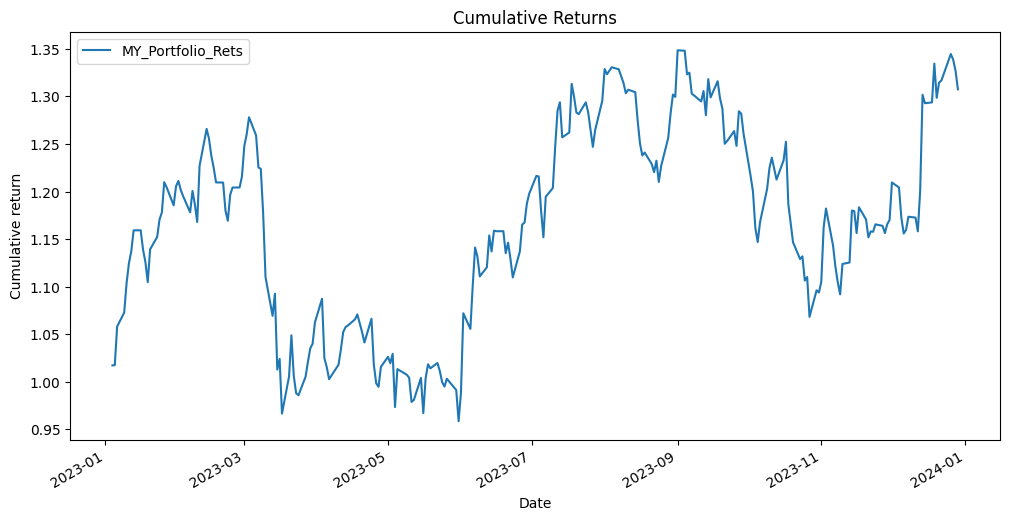

In [88]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(1, 1, 1)
C_port_ret.plot(ax=ax1)
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative return')
ax1.set_title('Cumulative Returns')
plt.show()

If we had simulated the possible outcomes of returns in 2021-Dec based on historical data, how would that look like?

In [89]:
# We can use the historical returns 'all_returns' to get the parameters of the simulations
## Calculate the covariance matrix:
returns = all_returns

T = 10/12
N_SIMS = 10 ** 5

cov_mat = returns.cov()
mu = np.mean(returns, axis=0).values*252
sigma = np.std(returns, axis=0).values*np.sqrt(252)

display(sigma)
display(mu)

array([0.15741674, 0.07394404, 0.08320206, 0.21444039, 0.84397334])

array([ 0.10786263, -0.01224721, -0.03165404,  0.15406005,  0.63875797])

In [90]:

## Perform the Cholesky decomposition of the covariance matrix:

def GBMsimulator(seed, So, mu, sigma, Cov, T, N):
    """
    Parameters
    seed:   seed of simulation
    So:     initial stocks' price
    mu:     expected return
    sigma:  volatility
    Cov:    covariance matrix
    T:      time period
    N:      number of increments
    """

    np.random.seed(seed)
    dim = np.size(So)
    t = np.linspace(0., T, int(N))
    A = np.linalg.cholesky(Cov)
    S = np.zeros([dim, int(N)])
    S[:, 0] = So
    for i in range(1, int(N)):
        drift = (mu - 0.5 * sigma**2) * (t[i] - t[i-1])
        Z = np.random.normal(0., 1., dim)
        diffusion = np.matmul(A, Z) * (np.sqrt(t[i] - t[i-1]))
        S[:, i] = S[:, i-1]*np.exp(drift + diffusion)
    return S, t

In [91]:
seed = 22

dim = len(w); T = 10/12; N_SIMS = 1000

S0 = np.array([1, 1, 1, 1, 1])
N_steps = int(T*252)

assets, time = GBMsimulator(seed, S0, mu, sigma, cov_mat, T, N_steps)


# Number of Simulations

np.random.seed(seed)


Simulated_Paths = np.zeros([N_SIMS, dim, N_steps])

Simulated_Paths[0, :, :] = assets

for k in range(1, N_SIMS):
    seed = int(np.random.uniform(1,2**32-1,1))
    Simulated_Paths[k, :, :] = GBMsimulator(seed, S0, mu, sigma, cov_mat, T, N_steps)[0]

# Plot one of the simulations, e.g. the 0th

#plt.figure(figsize = (16,8))
#plt.title('Multidimensional Correlated GBM', fontsize = 18)
#plt.xlabel('Time', fontsize = 18)

#for j in range(dim):
#    plt.plot(time, SS[0, j, 210])
#plt.show()


display(Simulated_Paths.shape)

(1000, 5, 210)

In [92]:
Simul_Last_Values = Simulated_Paths[:,:,(N_steps-1)]
#display(Simul_Last_Values.shape)
Simul_Last_Portf_Values = w.transpose().values*Simul_Last_Values
#display(Simul_Last_Portf_Values.shape)
X = pd.DataFrame(Simul_Last_Portf_Values).sum(axis=1)
display(X)

0     122.4289%
1     114.3938%
2     117.1559%
3     123.7954%
4     116.1075%
5     120.8158%
6     121.0048%
7     119.7538%
8     115.3898%
9     117.7287%
10    123.2661%
11    120.1748%
12    122.7771%
13    119.4905%
14    121.2567%
15    116.9078%
16    117.3311%
17    115.1362%
18    114.2339%
19    116.4017%
20    112.4566%
21    114.0675%
22    120.2267%
23    117.5927%
24    122.3222%
25    115.8123%
26    113.8429%
27    118.1853%
28    115.3333%
29    118.3641%
30    115.9306%
31    119.3562%
32    121.1040%
33    116.6521%
34    120.0017%
35    117.3374%
36    122.0965%
37    120.0714%
38    118.8374%
39    118.6407%
40    122.4916%
41    118.0177%
42    112.5539%
43    117.2094%
44    118.6176%
45    113.8590%
46    117.1172%
47    114.8488%
48    113.6998%
49    120.0991%
50    125.4019%
51    115.8363%
52    116.2950%
53    108.6833%
54    121.3207%
55    115.9366%
56    119.0326%
57    113.9870%
58    123.4213%
59    123.0900%
60    116.5325%
61    116.3228%
62    11

Portfolio Value Histogram:


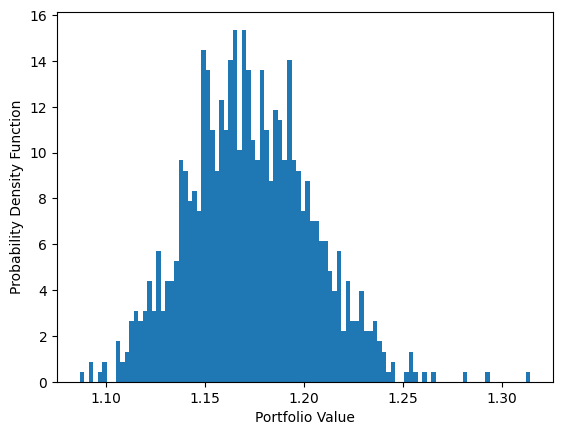

In [93]:
import matplotlib.pyplot as pl

print('Portfolio Value Histogram:')
pl.figure()
pl.hist(X,bins=100, density=True, stacked=True)
pl.xlabel('Portfolio Value')
pl.ylabel('Probability Density Function')
pl.show()
